# Deteksi Penyakit Kulit dengan Transfer Learning (VGG16 & EfficientNet)

## Latar Belakang
Penyakit kulit seperti melanoma dan psoriasis membutuhkan diagnosis cepat dan akurat.
Deep learning, khususnya Convolutional Neural Networks (CNN), dapat membantu klasifikasi gambar kulit.

## Tujuan
- Membangun model klasifikasi gambar kulit menggunakan transfer learning.
- Membandingkan performa VGG16 dan EfficientNet.


# **IMPORT LIBRARY**

In [ ]:
import os
import zipfile
import shutil
import gdown
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
import logging

# **LOAD DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path ke file ZIP dataset
melanoma_zip = '/content/drive/MyDrive/dataset_kulit/melanoma.zip'
psoriasis_zip = '/content/drive/MyDrive/dataset_kulit/psoriasis.zip'

# Fungsi untuk cek file
def check_file(path, name):
    if os.path.exists(path):
        print(f"File ditemukan: {name}")
    else:
        print(f"File TIDAK ditemukan: {name}")

# Cek keberadaan file ZIP
print("\nMemeriksa file ZIP dataset...\n")
check_file(melanoma_zip, 'melanoma.zip')
check_file(psoriasis_zip, 'psoriasis.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Memeriksa file ZIP dataset...

File ditemukan: melanoma.zip
File ditemukan: psoriasis.zip


In [ ]:
import zipfile
import os
import shutil
import time

def count_files(folder):
    return sum(
        1 for f in os.scandir(folder)
        if f.name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ) if os.path.exists(folder) else 0

def unzip_local(zip_path, drive_dest_path, expected_min_files=100):
    start = time.time()
    flag_file = os.path.join(drive_dest_path, '.extracted')

    # Skip jika flag ada atau file gambar sudah cukup banyak
    if os.path.exists(flag_file) or count_files(drive_dest_path) >= expected_min_files:
        print(f"[SKIP] Sudah diekstrak atau file sudah ada: {drive_dest_path}")
        return

    local_temp = '/content/temp_extract'
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(local_temp)
    except zipfile.BadZipFile:
        print(f"[ERROR] ZIP rusak: {zip_path}")
        return

    os.makedirs(drive_dest_path, exist_ok=True)
    moved_files = 0
    for root, dirs, files in os.walk(local_temp):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(drive_dest_path, file)
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                    moved_files += 1

    # Buat file flag hanya jika benar-benar menyalin
    with open(flag_file, 'w') as f:
        f.write('done')

    shutil.rmtree(local_temp)
    duration = time.time() - start
    print(f"[OK] Ekstraksi selesai ({moved_files} file) ➜ {drive_dest_path} dalam {duration:.2f} detik")

# Path ZIP & output
melanoma_zip = '/content/drive/MyDrive/dataset_kulit/melanoma.zip'
psoriasis_zip = '/content/drive/MyDrive/dataset_kulit/psoriasis.zip'

melanoma_extract = '/content/drive/MyDrive/dataset_kulit/melanoma/malignant'
psoriasis_extract = '/content/drive/MyDrive/dataset_kulit/psoriasis/PSORIASIS'

print("Memulai ekstraksi cepat dari lokal RAM...\n")
unzip_local(melanoma_zip, melanoma_extract, expected_min_files=100)
unzip_local(psoriasis_zip, psoriasis_extract, expected_min_files=100)

Memulai ekstraksi cepat dari lokal RAM...

[SKIP] Sudah diekstrak atau file sudah ada: /content/drive/MyDrive/dataset_kulit/melanoma/malignant
[SKIP] Sudah diekstrak atau file sudah ada: /content/drive/MyDrive/dataset_kulit/psoriasis/PSORIASIS


In [ ]:
import os

# Fungsi untuk menghitung jumlah gambar secara rekursif di dalam folder dan subfolder
def count_images_recursive(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        count += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return count

# Path folder utama dataset
melanoma_path = '/content/drive/MyDrive/dataset_kulit/melanoma/malignant'
psoriasis_path = '/content/drive/MyDrive/dataset_kulit/psoriasis/PSORIASIS'

# Hitung total gambar
melanoma_count = count_images_recursive(melanoma_path)
psoriasis_count = count_images_recursive(psoriasis_path)

# Cetak hasil
print("Total gambar Melanoma:", melanoma_count, "file")
print("Total gambar Psoriasis:", psoriasis_count, "file")

Total gambar Melanoma: 6590 file
Total gambar Psoriasis: 3807 file


In [ ]:
import os
import shutil
from pathlib import Path

# Folder sumber nested
melanoma_source = Path('/content/drive/MyDrive/dataset_kulit/melanoma/malignant')
psoriasis_source = Path('/content/drive/MyDrive/dataset_kulit/psoriasis/PSORIASIS')

# Folder tujuan akhir
melanoma_target = Path('/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma')
psoriasis_target = Path('/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis')

# Buat folder tujuan jika belum ada
melanoma_target.mkdir(parents=True, exist_ok=True)
psoriasis_target.mkdir(parents=True, exist_ok=True)

In [ ]:
# Fungsi: Salin semua file gambar dari subfolder ke 1 folder rata (flat)
def flatten_dataset(source_dir, target_dir):
    total_copied = 0
    total_skipped = 0

    for root, _, files in os.walk(source_dir):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = Path(root) / fname
                dst = target_dir / fname

                if dst.exists():
                    total_skipped += 1
                else:
                    try:
                        shutil.copy2(src, dst)
                        total_copied += 1
                    except Exception as e:
                        print(f"[ERROR] Gagal salin {src.name} | {e}")

    return total_copied, total_skipped

# **INFORMASI DATASET**

In [ ]:
print("Memproses folder MELANOMA")
copied_mel, skipped_mel = flatten_dataset(melanoma_source, melanoma_target)

print("Memproses folder PSORIASIS")
copied_pso, skipped_pso = flatten_dataset(psoriasis_source, psoriasis_target)

# Hasil
print("HASIL PEMINDAHAN")
print(f"Melanoma  : {copied_mel} file disalin, {skipped_mel} file dilewati (sudah ada)")
print(f"Psoriasis : {copied_pso} file disalin, {skipped_pso} file dilewati (sudah ada)")
print("Semua gambar dari subfolder telah diratakan ke final_dataset.")


Memproses folder MELANOMA

Memproses folder PSORIASIS

HASIL PEMINDAHAN
Melanoma  : 0 file disalin, 6590 file dilewati (sudah ada)
Psoriasis : 0 file disalin, 3807 file dilewati (sudah ada)
Semua gambar dari subfolder telah diratakan ke final_dataset.


In [ ]:
import os

melanoma_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

melanoma_count = len([f for f in os.listdir(melanoma_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
psoriasis_count = len([f for f in os.listdir(psoriasis_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
total_count = melanoma_count + psoriasis_count

print("Jumlah gambar di folder final_dataset:")
print(f"- Melanoma  : {melanoma_count} file")
print(f"- Psoriasis : {psoriasis_count} file")
print(f"- Total     : {total_count} file")

Jumlah gambar di folder final_dataset:
- Melanoma  : 6590 file
- Psoriasis : 3807 file
- Total     : 10397 file


# **EXPLORARY DATA ANALYST**

Contoh gambar Melanoma:


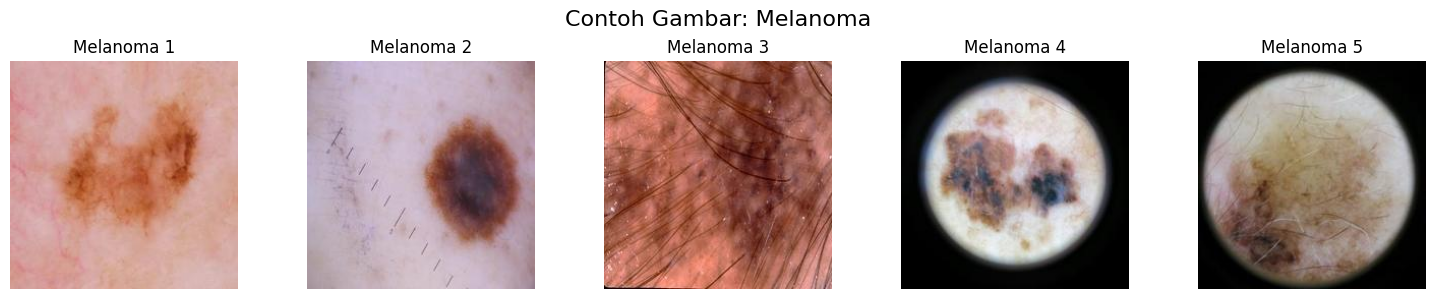

Contoh gambar Psoriasis:


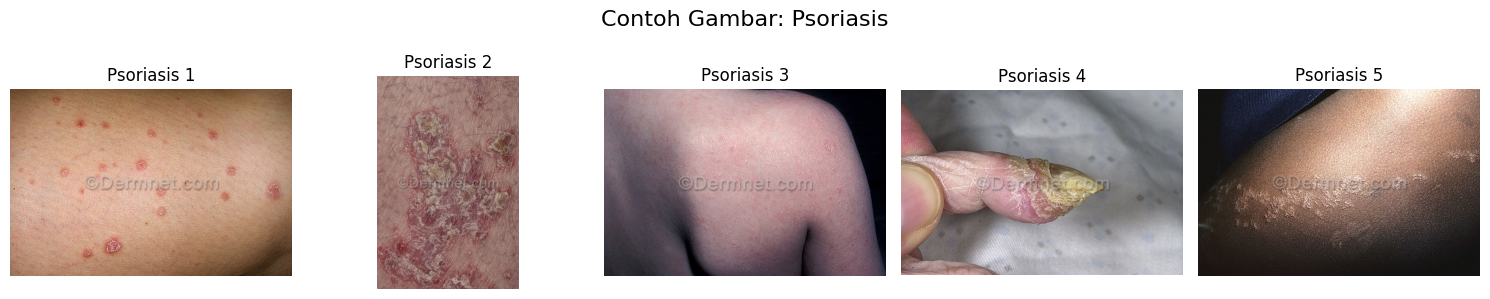

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path final dataset
melanoma_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

# Fungsi untuk menampilkan beberapa contoh gambar dari folder
def show_final_samples(folder_path, label, count=5):
    # Ambil semua file gambar yang valid
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Batasi jumlah gambar yang ditampilkan
    files = files[:count]

    # Buat figure untuk plot
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        try:
            img = mpimg.imread(img_path)
            plt.subplot(1, count, i + 1)
            plt.imshow(img)
            plt.title(f"{label} {i+1}")
            plt.axis('off')
        except Exception as e:
            print(f"Gagal menampilkan {img_path}: {e}")

    plt.suptitle(f"Contoh Gambar: {label}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Tampilkan contoh gambar dari masing-masing kelas
print("Contoh gambar Melanoma:")
show_final_samples(melanoma_final, 'Melanoma', count=5)

print("Contoh gambar Psoriasis:")
show_final_samples(psoriasis_final, 'Psoriasis', count=5)

In [ ]:
import os

# Path ke folder final dataset di Google Drive
melanoma_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

# Ambil dan urutkan file gambar
melanoma_files = sorted([f for f in os.listdir(melanoma_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
psoriasis_files = sorted([f for f in os.listdir(psoriasis_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Tampilkan 10 file pertama dari masing-masing folder
print("File Melanoma (10 pertama):")
for f in melanoma_files[:10]:
    print(f)

print("\nFile Psoriasis (10 pertama):")
for f in psoriasis_files[:10]:
    print(f)

# (Opsional) Tampilkan jumlah total file
print(f"\nTotal file Melanoma  : {len(melanoma_files)}")
print(f"Total file Psoriasis : {len(psoriasis_files)}")

File Melanoma (10 pertama):
1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
1005.jpg
1006.jpg

File Psoriasis (10 pertama):
07acne06270532.jpg
08LSAAnal062804.jpg
08LSASkin.jpg
08LichenPlanusTongue.jpg
08OilSpotPsoriasis1027.jpg
08PsoriasisAnalPink1216.jpg
08PsoriasisGroin.jpg
08PsoriasisGroin1.jpg
08PsoriasisIntertrigo.jpg
08PsoriasisIntertrigo1006.jpg

Total file Melanoma  : 6590
Total file Psoriasis : 3807


In [ ]:
import os
from PIL import Image

# Path folder dataset akhir (Google Drive)
melanoma_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

# Ambil daftar file gambar (jpg, jpeg, png)
melanoma_files = [f for f in os.listdir(melanoma_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
psoriasis_files = [f for f in os.listdir(psoriasis_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Hitung jumlah gambar per kelas
melanoma_count = len(melanoma_files)
psoriasis_count = len(psoriasis_files)

# Ambil ukuran gambar contoh dari melanoma
if melanoma_files:
    img_example_path = os.path.join(melanoma_final, melanoma_files[0])
    img_example = Image.open(img_example_path)
    img_size = img_example.size
else:
    img_size = (0, 0)

# Tampilkan deskripsi dataset
print("\nDESKRIPSI DATASET CNN - SKIN DISEASE CLASSIFICATION")
print("=" * 60)
print(f"Jumlah gambar Melanoma   : {melanoma_count} file")
print(f"Jumlah gambar Psoriasis  : {psoriasis_count} file")
print(f"Total gambar             : {melanoma_count + psoriasis_count} file")
print(f"Format gambar            : JPG / PNG")
print(f"Ukuran gambar asli       : {img_size} (akan di-resize ke 224 x 224)")
print("Struktur folder dataset  :")
print("  final_dataset/")
print("     ├── melanoma/     --> label: 1")
print("     └── psoriasis/    --> label: 2")
print("=" * 60)


DESKRIPSI DATASET CNN - SKIN DISEASE CLASSIFICATION
Jumlah gambar Melanoma   : 6590 file
Jumlah gambar Psoriasis  : 3807 file
Total gambar             : 10397 file
Format gambar            : JPG / PNG
Ukuran gambar asli       : (224, 224) (akan di-resize ke 224 x 224)
Struktur folder dataset  :
  final_dataset/
     ├── melanoma/     --> label: 1
     └── psoriasis/    --> label: 2


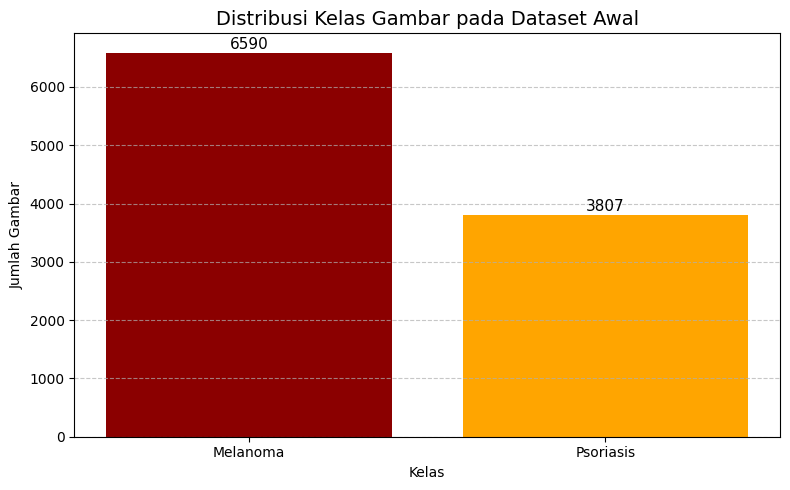

Gambar disimpan di: /content/drive/MyDrive/dataset_kulit/distribusi_kelas_awal.png


In [ ]:
import os
import matplotlib.pyplot as plt

# Pastikan path sudah sesuai (Google Drive)
melanoma_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_final = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

# Hitung jumlah file gambar valid
melanoma_count = len([f for f in os.listdir(melanoma_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
psoriasis_count = len([f for f in os.listdir(psoriasis_final) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Label dan data
labels = ['Melanoma', 'Psoriasis']
counts = [melanoma_count, psoriasis_count]
colors = ['darkred', 'orange']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=colors)

# Tambahkan angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, str(yval), ha='center', va='bottom', fontsize=11)

plt.title('Distribusi Kelas Gambar pada Dataset Awal', fontsize=14)
plt.ylabel('Jumlah Gambar')
plt.xlabel('Kelas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Simpan ke PNG di Drive
output_path = '/content/drive/MyDrive/dataset_kulit/distribusi_kelas_awal.png'
plt.savefig(output_path, format='png', dpi=300)

plt.show()

print(f"Gambar disimpan di: {output_path}")

In [ ]:
import os
from PIL import Image

# Fungsi untuk mengambil ukuran semua gambar di folder
def get_image_sizes(folder):
    sizes = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(folder, fname)
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"Lewati file: {fname} ({e})")
    return sizes

# Hitung rata-rata ukuran gambar (width, height)
def compute_avg_size(size_list):
    if not size_list:
        return (0, 0)
    total_w = sum(w for w, h in size_list)
    total_h = sum(h for w, h in size_list)
    count = len(size_list)
    return (int(total_w / count), int(total_h / count))

# Path dataset di Google Drive (Colab)
melanoma_dir = '/content/drive/MyDrive/dataset_kulit/final_dataset/melanoma'
psoriasis_dir = '/content/drive/MyDrive/dataset_kulit/final_dataset/psoriasis'

# Ambil ukuran semua gambar
mel_sizes = get_image_sizes(melanoma_dir)
psor_sizes = get_image_sizes(psoriasis_dir)

# Hitung rata-rata
avg_mel = compute_avg_size(mel_sizes)
avg_psor = compute_avg_size(psor_sizes)

# Tampilkan hasil
print("\nRATA-RATA UKURAN CITRA")
print("=" * 35)
print(f"Melanoma   : {avg_mel[0]} x {avg_mel[1]} px")
print(f"Psoriasis  : {avg_psor[0]} x {avg_psor[1]} px")


RATA-RATA UKURAN CITRA
Melanoma   : 224 x 224 px
Psoriasis  : 621 x 527 px


# **PREPROCESSING**

In [ ]:
import os
import shutil
import hashlib
import json
from pathlib import Path
from collections import defaultdict

# Konfigurasi global
LOG_PATH = '/content/drive/MyDrive/dataset_kulit/logs/dupe_hash_log.json'
VALID_EXT = ('.jpg', '.jpeg', '.png')

def compute_md5(file_path):
    try:
        with open(file_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

def load_hash_log(log_path):
    if os.path.exists(log_path):
        try:
            with open(log_path, 'r') as f:
                return json.load(f)
        except json.JSONDecodeError:
            print("Peringatan: log lama rusak. Log di-reset.")
    return {}

def save_hash_log(log_path, hash_log):
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    with open(log_path, 'w') as f:
        json.dump(hash_log, f, indent=2)

def copy_unique_images(source_root, target_root, labels=('melanoma', 'psoriasis'), log_path=LOG_PATH):
    source_root = Path(source_root)
    target_root = Path(target_root)
    hash_log = load_hash_log(log_path)
    known_hashes = set(hash_log.values())

    print(f"Menyalin hanya gambar unik dari {source_root} ke {target_root}")

    for label in labels:
        src_folder = source_root / label
        dst_folder = target_root / label

        if not src_folder.exists():
            print(f"[SKIP] Folder sumber tidak ditemukan: {src_folder}")
            continue

        dst_folder.mkdir(parents=True, exist_ok=True)

        copied = 0
        for img in src_folder.glob("*.*"):
            if img.suffix.lower() not in VALID_EXT:
                continue

            file_hash = compute_md5(img)
            if file_hash and file_hash not in known_hashes:
                dst_file = dst_folder / img.name
                if not dst_file.exists():
                    shutil.copy(img, dst_file)
                    hash_log[str(dst_file)] = file_hash
                    known_hashes.add(file_hash)
                    copied += 1

        print(f"{label}: {copied} gambar baru disalin.")

    save_hash_log(log_path, hash_log)
    print("Penyalinan gambar unik selesai.\n")

def remove_duplicate_images_summary(base_dir, labels=('melanoma', 'psoriasis'), log_path=LOG_PATH):
    base_dir = Path(base_dir)
    hash_dict = defaultdict(list)
    hash_log = load_hash_log(log_path)

    total_checked = 0
    total_deleted = 0

    print(f"Memeriksa duplikat gambar di folder: {base_dir}\n")

    for label in labels:
        folder = base_dir / label
        if not folder.exists():
            print(f"[SKIP] Folder tidak ditemukan: {folder}")
            continue

        for img_path in folder.glob("*.*"):
            if img_path.suffix.lower() not in VALID_EXT:
                continue

            total_checked += 1
            str_path = str(img_path)

            if str_path in hash_log:
                file_hash = hash_log[str_path]
            else:
                try:
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    hash_log[str_path] = file_hash
                except:
                    continue

            hash_dict[file_hash].append(img_path)

    for file_list in hash_dict.values():
        if len(file_list) > 1:
            for duplicate_file in file_list[1:]:
                try:
                    duplicate_file.unlink()
                    total_deleted += 1
                    hash_log.pop(str(duplicate_file), None)
                except:
                    continue

    save_hash_log(log_path, hash_log)

    print("RINGKASAN DETEKSI DUPLIKAT")
    print("=" * 55)
    print(f"Total file dicek     : {total_checked}")
    print(f"Duplikat dihapus     : {total_deleted}")
    print("=" * 55)
    if total_deleted == 0:
        print("Tidak ada gambar duplikat baru ditemukan")
    else:
        print("Duplikat berhasil dibersihkan")

In [ ]:
copy_unique_images(
    source_root='/content/drive/MyDrive/dataset_kulit/final_dataset',
    target_root='/content/drive/MyDrive/dataset_kulit/clean_dataset',
    labels=('melanoma', 'psoriasis'),
    log_path=LOG_PATH
)

remove_duplicate_images_summary(
    base_dir='/content/drive/MyDrive/dataset_kulit/clean_dataset',
    labels=('melanoma', 'psoriasis'),
    log_path=LOG_PATH
)

Menyalin hanya gambar unik dari /content/drive/MyDrive/dataset_kulit/final_dataset ke /content/drive/MyDrive/dataset_kulit/clean_dataset
melanoma: 0 gambar baru disalin.
psoriasis: 0 gambar baru disalin.
Penyalinan gambar unik selesai.

Memeriksa duplikat gambar di folder: /content/drive/MyDrive/dataset_kulit/clean_dataset


RINGKASAN DETEKSI DUPLIKAT
Total file dicek     : 2160
Duplikat dihapus     : 0
Tidak ada gambar duplikat baru ditemukan.



In [ ]:
total_awal = 10397
duplikat_dihapus = 1794
unik_akhir = 8601

print(f"Total gambar awal    : {total_awal}")
print(f"Duplikat dihapus     : {duplikat_dihapus}")
print(f"Total gambar bersih  : {unik_akhir}\n")

Total gambar awal    : 10397
Duplikat dihapus     : 1794
Total gambar bersih  : 8601



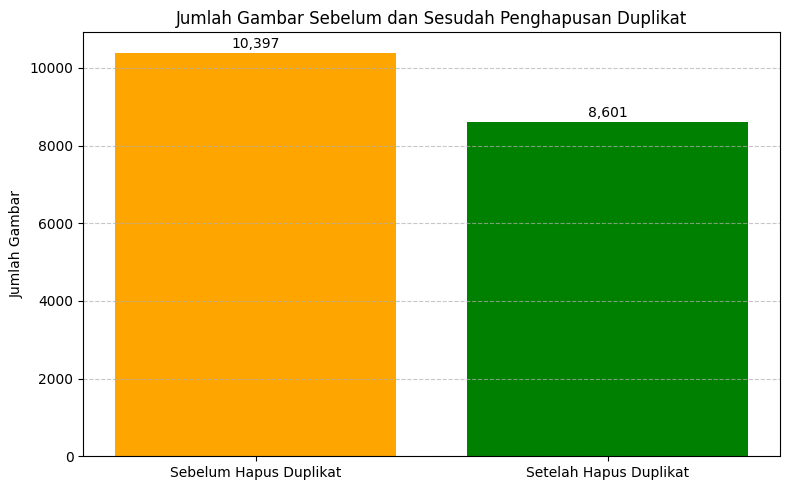

Gambar bar chart disimpan di: /content/drive/MyDrive/dataset_kulit/bar_chart_duplikat.png


In [ ]:
# Data untuk bar chart
labels = ['Sebelum Hapus Duplikat', 'Setelah Hapus Duplikat']
values = [total_awal, unik_akhir]
colors = ['orange', 'green']

# Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 50,
        f"{int(yval):,}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Jumlah Gambar Sebelum dan Sesudah Penghapusan Duplikat')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

output_bar = '/content/drive/MyDrive/dataset_kulit/bar_chart_duplikat.png'
plt.savefig(output_bar, format='png', dpi=300)
plt.show()

print(f"Gambar bar chart disimpan di: {output_bar}")

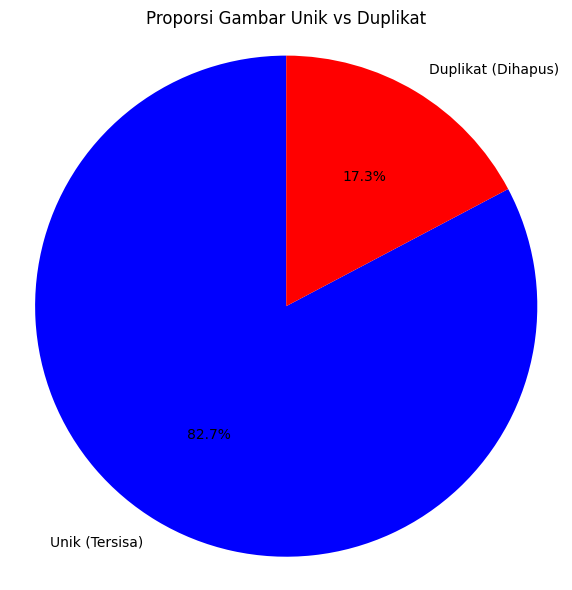

Gambar pie chart disimpan di: /content/drive/MyDrive/dataset_kulit/pie_chart_duplikat.png


In [ ]:
# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(
    [unik_akhir, duplikat_dihapus],
    labels=['Unik (Tersisa)', 'Duplikat (Dihapus)'],
    colors=['blue', 'red'],
    autopct='%1.1f%%',
    startangle=90
)

plt.title('Proporsi Gambar Unik vs Duplikat')
plt.axis('equal')
plt.tight_layout()

output_pie = '/content/drive/MyDrive/dataset_kulit/pie_chart_duplikat.png'
plt.savefig(output_pie, format='png', dpi=300)
plt.show()

print(f"Gambar pie chart disimpan di: {output_pie}")

In [ ]:
def is_image_corrupt(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        with Image.open(image_path) as img:
            img.load()
        return False
    except:
        return True

def check_and_remove_corrupt_images(base_dir, labels=('melanoma', 'psoriasis'), log_path=None):
    base_dir = Path(base_dir)
    corrupt_files = []
    total_checked = 0

    print(f"Memeriksa gambar rusak di: {base_dir}\n")

    for label in labels:
        folder = base_dir / label
        if not folder.exists():
            print(f"[SKIP] Folder tidak ditemukan: {folder}")
            continue

        print(f"Folder: {label}")
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = folder / fname
                total_checked += 1
                if is_image_corrupt(img_path):
                    corrupt_files.append(str(img_path))
                    print(f"[CORRUPT] {img_path.name}")

    print(f"\nTotal gambar diperiksa  : {total_checked}")
    print(f"Total gambar corrupt    : {len(corrupt_files)}")

    for path in corrupt_files:
        try:
            os.remove(path)
            print(f"Dihapus: {path}")
        except Exception as e:
            print(f"[ERROR] Gagal menghapus {path} → {e}")

    if log_path:
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        with open(log_path, 'w') as f:
            json.dump(corrupt_files, f, indent=2)
        print(f"\nLog disimpan di: {log_path}")

    return corrupt_files

In [ ]:
check_and_remove_corrupt_images(
    base_dir=Path('/content/drive/MyDrive/dataset_kulit/clean_dataset'),
    log_path='/content/drive/MyDrive/dataset_kulit/logs/corrupt_image_log.json'
)

Memeriksa gambar rusak di: /content/drive/MyDrive/dataset_kulit/clean_dataset

Folder: melanoma
Folder: psoriasis

Total gambar diperiksa  : 2160
Total gambar corrupt    : 0

Log disimpan di: /content/drive/MyDrive/dataset_kulit/logs/corrupt_image_log.json


[]

In [ ]:
import os
import json
import cv2
from pathlib import Path

def check_and_log_blurry_images(base_dir, labels=('melanoma', 'psoriasis'), threshold=100.0, log_path=None):
    base_dir = Path(base_dir)
    blurry_files = []
    blur_log = {}

    print(f"\nMemulai pemeriksaan gambar buram (threshold < {threshold})\n")

    for label in labels:
        folder = base_dir / label
        if not folder.exists():
            print(f"[SKIP] Folder tidak ditemukan: {folder}")
            continue

        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"[{label}] Jumlah file ditemukan: {len(files)}")

        for fname in files:
            img_path = folder / fname
            image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            variance = cv2.Laplacian(image, cv2.CV_64F).var()
            score = round(variance, 2)
            blur_log[str(img_path.relative_to(base_dir))] = score

            if score < threshold:
                blurry_files.append((str(img_path), score))
                print(f"[BLUR] {fname} → Variance: {score}")

    if log_path:
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        with open(log_path, 'w') as f:
            json.dump(blur_log, f, indent=2)
        print(f"\nLog disimpan di: {log_path}")

    print(f"\nTotal gambar diperiksa: {len(blur_log)}")
    print(f"Total gambar buram    : {len(blurry_files)}")

    return blurry_files

In [ ]:
blurry_images = check_and_log_blurry_images(
    base_dir='/content/drive/MyDrive/dataset_kulit/clean_dataset',
    threshold=300.0,
    log_path='/content/drive/MyDrive/dataset_kulit/logs/blur_detection_log.json'
)


Memulai pemeriksaan gambar buram (threshold < 300.0)

[melanoma] Jumlah file ditemukan: 656
[psoriasis] Jumlah file ditemukan: 1504

Log disimpan di: /content/drive/MyDrive/dataset_kulit/logs/blur_detection_log.json

Total gambar diperiksa: 2160
Total gambar buram    : 0


In [ ]:
import os
import json

def delete_blurry_images_from_log(log_path, base_dir, threshold=300.0, output_log_path=None):

    # Load hasil deteksi dari JSON
    with open(log_path, 'r') as f:
        blur_log = json.load(f)

    deleted = []
    not_found = []

    for relative_path, score in blur_log.items():
        if score < threshold:
            full_path = os.path.join(base_dir, relative_path)

            if os.path.exists(full_path):
                try:
                    os.remove(full_path)
                    deleted.append(relative_path)
                except Exception as e:
                    print(f"Gagal hapus {full_path} → {e}")
            else:
                not_found.append(relative_path)

    # Simpan log penghapusan
    if output_log_path:
        os.makedirs(os.path.dirname(output_log_path), exist_ok=True)
        with open(output_log_path, 'w') as f:
            json.dump({"deleted": deleted}, f, indent=2)

    print("\nRINGKASAN PENGHAPUSAN")
    print(f"Total gambar buram terhapus: {len(deleted):,}")
    print(f"Tidak ditemukan di disk     : {len(not_found):,}")
    if output_log_path:
        print(f"Log disimpan ke            : {output_log_path}")

In [ ]:
# Parameter path
base_dir = '/content/drive/MyDrive/dataset_kulit/clean_dataset'
log_path = '/content/drive/MyDrive/dataset_kulit/logs/blur_detection_log.json'
deleted_log_path = '/content/drive/MyDrive/dataset_kulit/logs/blur_deleted_only_log.json'

# Jalankan penghapusan
delete_blurry_images_from_log(
    log_path=log_path,
    base_dir=base_dir,
    threshold=300.0,
    output_log_path=deleted_log_path
)


RINGKASAN PENGHAPUSAN
Total gambar buram terhapus: 0
Tidak ditemukan di disk     : 0
Log disimpan ke            : /content/drive/MyDrive/dataset_kulit/logs/blur_deleted_only_log.json


In [ ]:
import json
import csv
import os

def export_blur_log_with_scores_to_csv(detect_log_path, deleted_log_path, output_csv_path, threshold=300.0):
    # Load deteksi & penghapusan
    with open(detect_log_path, 'r') as f:
        detection_log = json.load(f)

    with open(deleted_log_path, 'r') as f:
        deleted_log = json.load(f)

    deleted_files = deleted_log.get("deleted", [])

    # Buat baris: No, Path, Score
    rows = []
    for i, rel_path in enumerate(deleted_files, 1):
        score = detection_log.get(rel_path, "N/A")
        rows.append([i, rel_path, score])

    # Simpan ke CSV
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["No", "Relative Path", "Variance Score"])
        writer.writerows(rows)

    print(f"CSV dengan skor disimpan ke: {output_csv_path}")

In [ ]:
export_blur_log_with_scores_to_csv(
    detect_log_path='/content/drive/MyDrive/dataset_kulit/logs/blur_detection_log.json',
    deleted_log_path='/content/drive/MyDrive/dataset_kulit/logs/blur_deleted_only_log.json',
    output_csv_path='/content/drive/MyDrive/dataset_kulit/logs/blur_deleted_only_log.csv'
)

CSV dengan skor disimpan ke: /content/drive/MyDrive/dataset_kulit/logs/blur_deleted_only_log.csv


In [ ]:
import matplotlib.pyplot as plt

def plot_blur_bar_chart(detected, deleted, output_path):
    plt.figure(figsize=(8, 5))
    labels = ['Terdeteksi Buram', 'Berhasil Dihapus']
    values = [detected, deleted]
    colors = ['orange', 'green']

    bars = plt.bar(labels, values, color=colors)
    for bar in bars:
        y = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, y + 30, f"{y:,}", ha='center', fontsize=11)

    plt.title('Jumlah Gambar Buram Terdeteksi vs Dihapus')
    plt.ylabel('Jumlah Gambar')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Bar chart disimpan di: {output_path}")

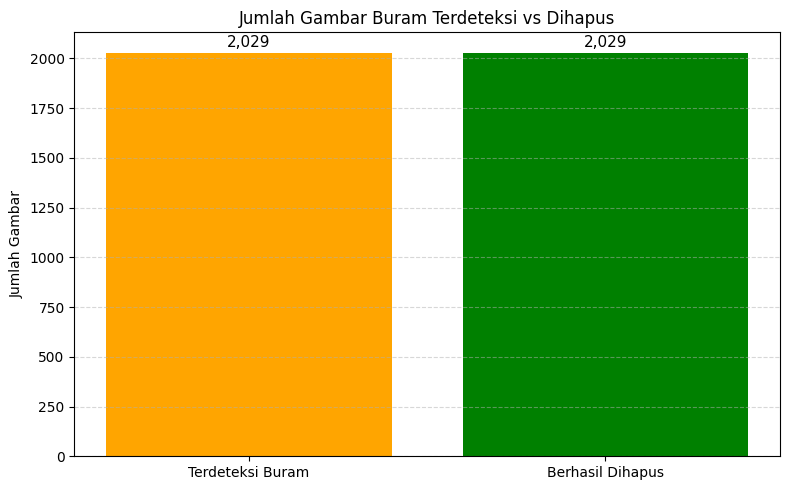

Bar chart disimpan di: /content/drive/MyDrive/dataset_kulit/bar_chart_blur.png


In [ ]:
detected = 2029
deleted = 2029

plot_blur_bar_chart(
    detected=detected,
    deleted=deleted,
    output_path='/content/drive/MyDrive/dataset_kulit/bar_chart_blur.png'
)

In [ ]:
def plot_blur_pie_chart(detected, deleted, output_path):
    sisa = detected - deleted if detected > deleted else 0

    plt.figure(figsize=(6, 6))
    plt.pie(
        [deleted, sisa],
        labels=['Berhasil Dihapus', 'Tidak Terhapus'],
        colors=['green', 'red'],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title('Proporsi Penghapusan dari Gambar Buram')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Pie chart disimpan di: {output_path}")

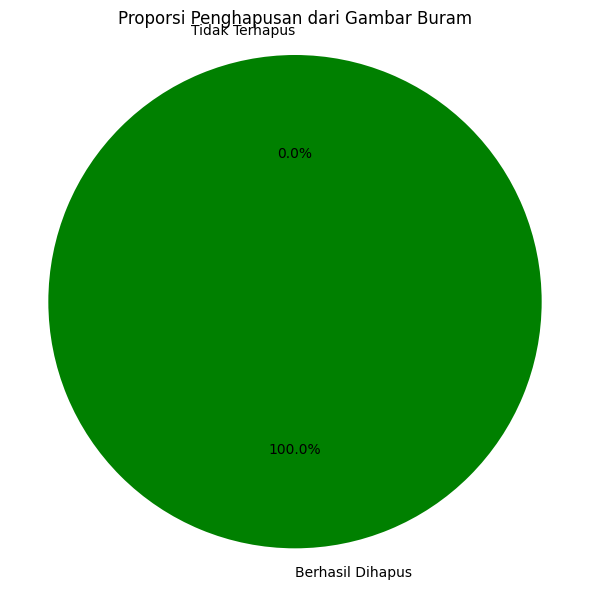

Pie chart disimpan di: /content/drive/MyDrive/dataset_kulit/pie_chart_blur.png


In [ ]:
plot_blur_pie_chart(
    detected=2029,
    deleted=2029,
    output_path='/content/drive/MyDrive/dataset_kulit/pie_chart_blur.png'
)

In [ ]:
from PIL import Image
import os

def check_small_images_verbose(base_dir, labels=('melanoma', 'psoriasis'), min_size=(100, 100)):
    too_small = []

    print(f"Memulai pemeriksaan ukuran gambar < {min_size[0]}x{min_size[1]} px\n")

    for label in labels:
        folder = os.path.join(base_dir, label)

        if not os.path.exists(folder):
            print(f"[SKIP] Folder tidak ditemukan: {folder}")
            continue

        print(f"Folder: {label}")
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        width, height = img.size
                        if width < min_size[0] or height < min_size[1]:
                            too_small.append((path, (width, height)))
                except Exception as e:
                    print(f"[ERROR] Gagal membaca: {fname} → {e}")

    return too_small

In [ ]:
small_images = check_small_images_verbose(
    base_dir='/content/drive/MyDrive/dataset_kulit/clean_dataset',
    min_size=(100, 100)
)

# Ringkasan Hasil
print("\nHASIL DETEKSI GAMBAR DENGAN UKURAN TERLALU KECIL")
print("=" * 60)

if small_images:
    print(f"Ditemukan {len(small_images)} gambar yang lebih kecil dari 100x100 px:\n")
    for i, (f, size) in enumerate(small_images, 1):
        label = os.path.basename(os.path.dirname(f))
        print(f"{i:02d}. [{label}] {os.path.basename(f)} → Ukuran: {size}")
else:
    print("Tidak ditemukan gambar dengan ukuran di bawah batas minimum.")

Memulai pemeriksaan ukuran gambar < 100x100 px

Folder: melanoma
Folder: psoriasis

HASIL DETEKSI GAMBAR DENGAN UKURAN TERLALU KECIL
Tidak ditemukan gambar dengan ukuran di bawah batas minimum.


In [ ]:
import os
from PIL import Image

def check_missing_values(base_dir, labels=('melanoma', 'psoriasis')):
    missing = {
        'file_not_found': [],
        'zero_byte_file': [],
        'unreadable': [],
        'zero_dimension': []
    }

    print(f"\nMemulai pengecekan missing values di: {base_dir}\n")

    for label in labels:
        folder = os.path.join(base_dir, label)

        # Folder tidak ditemukan
        if not os.path.exists(folder):
            print(f"[SKIP] Folder tidak ditemukan: {folder}")
            missing['file_not_found'].append(folder)
            continue

        for fname in os.listdir(folder):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            path = os.path.join(folder, fname)

            # File kosong (0 byte)
            if os.path.getsize(path) == 0:
                missing['zero_byte_file'].append(path)
                continue

            # Cek bisa dibaca atau tidak
            try:
                with Image.open(path) as img:
                    img.load()
            except Exception:
                missing['unreadable'].append(path)
                continue

            # Ukuran 0x0
            if img.size[0] == 0 or img.size[1] == 0:
                missing['zero_dimension'].append(path)

    return missing

In [ ]:
missing_report = check_missing_values('/content/drive/MyDrive/dataset_kulit/clean_dataset')

print("\nHASIL CEK MISSING VALUES")
print("=" * 60)
total_issues = 0

for category, files in missing_report.items():
    if files:
        print(f"\n{category.replace('_', ' ').title()} ({len(files)} file):")
        for f in files:
            print(f"  - {f}")
        total_issues += len(files)

if total_issues == 0:
    print("\nTidak ditemukan file rusak, kosong, atau ukuran nol.")
else:
    print(f"\nTotal file bermasalah ditemukan: {total_issues}")


Memulai pengecekan missing values di: /content/drive/MyDrive/dataset_kulit/clean_dataset


HASIL CEK MISSING VALUES

Tidak ditemukan file rusak, kosong, atau ukuran nol.


In [ ]:
import os

# Label yang diperbolehkan
expected_labels = ['melanoma', 'psoriasis']

# Ganti path dengan direktori dataset yang sesuai
dataset_path = '/content/drive/MyDrive/dataset_kulit/clean_dataset'

def validate_label_structure(path, expected_labels):
    if not os.path.exists(path):
        print(f"Folder dataset tidak ditemukan: {path}")
        return

    actual_labels = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

    # Cek folder label
    print("Folder label ditemukan:", actual_labels)
    wrong_labels = [lbl for lbl in actual_labels if lbl not in expected_labels]

    if wrong_labels:
        print("\nFolder label TIDAK valid:")
        for lbl in wrong_labels:
            print(f"  - {lbl}")
    else:
        print("\nSemua folder label valid.")

    # Cek isi setiap folder label
    for lbl in expected_labels:
        folder = os.path.join(path, lbl)
        if not os.path.exists(folder):
            print(f"\nFolder label hilang: {lbl}")
            continue

        print(f"\nMemeriksa isi folder: {lbl}")
        files = os.listdir(folder)
        non_image_files = [f for f in files if not f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if non_image_files:
            print(f"File tidak valid ditemukan di folder '{lbl}':")
            for f in non_image_files:
                print(f"    - {f}")
        else:
            print("Semua file adalah gambar (.jpg/.jpeg/.png).")

# Jalankan validasi struktur
validate_label_structure(dataset_path, expected_labels)

Folder label ditemukan: ['melanoma', 'psoriasis']

Semua folder label valid.

Memeriksa isi folder: melanoma
Semua file adalah gambar (.jpg/.jpeg/.png).

Memeriksa isi folder: psoriasis
Semua file adalah gambar (.jpg/.jpeg/.png).


In [ ]:
from PIL import Image
import os

def check_nonstandard_image_sizes(base_dir, expected_size=(224, 224)):
    non_standard = []

    for label in ['melanoma', 'psoriasis']:
        folder = os.path.join(base_dir, label)
        if not os.path.exists(folder):
            print(f"Folder tidak ditemukan: {folder}")
            continue

        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        if img.size != expected_size:
                            non_standard.append((path, img.size))
                except Exception as e:
                    print(f"Gagal membaca {path}: {e}")
                    continue

    return non_standard

# Jalankan pemeriksaan
dataset_path = '/content/drive/MyDrive/dataset_kulit/clean_dataset'
nonstandard_images = check_nonstandard_image_sizes(dataset_path, expected_size=(224, 224))

# Tampilkan hasil
print("\nHASIL CEK GAMBAR NON-STANDAR (224 x 224)")
print("=" * 60)
if nonstandard_images:
    print(f"Ditemukan {len(nonstandard_images)} gambar dengan ukuran selain 224x224.\nContoh gambar:")
    for path, size in nonstandard_images[:10]:
        print(f"  - {path} | Ukuran: {size}")
else:
    print("Semua gambar memiliki ukuran standar 224 x 224.")


HASIL CEK GAMBAR NON-STANDAR (224 x 224)
Ditemukan 1504 gambar dengan ukuran selain 224x224.
Contoh gambar:
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/Psoriasis-Chronic-Plaque-140.jpg | Ukuran: (720, 496)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/17_4.jpg | Ukuran: (294, 222)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/psoriasis-palms-soles-117.jpg | Ukuran: (720, 472)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/Psoriasis-treatment-5.jpg | Ukuran: (496, 720)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/t-Psoriasis-Chronic-Plaque-142.jpg | Ukuran: (720, 496)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/t-pityriasis-rubra-pilaris-62.jpg | Ukuran: (477, 720)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/08biteLine110105.jpg | Ukuran: (720, 480)
  - /content/drive/MyDrive/dataset_kulit/clean_dataset/psoriasis/Psoriasis-Guttate-29.jpg | Ukuran: (

In [ ]:
from PIL import Image
from tqdm import tqdm
import os

# Path input dan output
input_root = '/content/drive/MyDrive/dataset_kulit/clean_dataset'
output_root = '/content/drive/MyDrive/dataset_kulit/rgb_dataset'

# Label kelas
labels = ['melanoma', 'psoriasis']

# Buat folder output
os.makedirs(output_root, exist_ok=True)
for label in labels:
    os.makedirs(os.path.join(output_root, label), exist_ok=True)

# Untuk rekap data
input_counts = {}
converted_counts = {}
skipped_rgb_counts = {}
skipped_exists_counts = {}

# Fungsi konversi ke RGB
def convert_to_rgb_and_save(src_dir, dst_dir):
    success = 0
    skipped_rgb = 0
    skipped_exists = 0

    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for fname in tqdm(files, desc=f"Memproses {os.path.basename(src_dir)}"):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)

        # Skip jika sudah ada file hasil konversi
        if os.path.exists(dst_path):
            skipped_exists += 1
            continue

        try:
            with Image.open(src_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                    img.save(dst_path)
                    success += 1
                else:
                    # Tetap simpan ulang jika tidak ada di output
                    img.save(dst_path)
                    skipped_rgb += 1
        except Exception as e:
            print(f"Gagal konversi {fname}: {e}")

    return success, skipped_rgb, skipped_exists

# Proses semua kelas
for label in labels:
    input_dir = os.path.join(input_root, label)
    output_dir = os.path.join(output_root, label)

    if not os.path.exists(input_dir):
        print(f"[SKIP] Folder tidak ditemukan: {input_dir}")
        continue

    files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    input_counts[label] = len(files)

    converted, skipped_rgb, skipped_exists = convert_to_rgb_and_save(input_dir, output_dir)

    converted_counts[label] = converted
    skipped_rgb_counts[label] = skipped_rgb
    skipped_exists_counts[label] = skipped_exists

# Ringkasan Akhir
print("\nRingkasan Konversi RGB")
print("=" * 40)
for label in labels:
    print(f"\n{label.upper()}")
    print(f"  Total file input        : {input_counts.get(label, 0):,}")
    print(f"  Berhasil dikonversi     : {converted_counts.get(label, 0):,}")
    print(f"  Dilewati (sudah RGB)    : {skipped_rgb_counts.get(label, 0):,}")
    print(f"  Dilewati (sudah ada)    : {skipped_exists_counts.get(label, 0):,}")

Memproses psoriasis: 100%|██████████| 1504/1504 [00:04<00:00, 353.29it/s]


Ringkasan Konversi RGB

MELANOMA
  Total file input        : 656
  Berhasil dikonversi     : 0
  Dilewati (sudah RGB)    : 0
  Dilewati (sudah ada)    : 656

PSORIASIS
  Total file input        : 1,504
  Berhasil dikonversi     : 0
  Dilewati (sudah RGB)    : 0
  Dilewati (sudah ada)    : 1,504


In [ ]:
# RINGKASAN AKHIR
print("\nRINGKASAN KONVERSI KE RGB")
print("=" * 60)

# Total keseluruhan
total_input = sum(input_counts.values())
total_converted = sum(converted_counts.values())
total_skipped_rgb = sum(skipped_rgb_counts.values())
total_skipped_exists = sum(skipped_exists_counts.values())
total_output = total_converted + total_skipped_rgb + total_skipped_exists

# Per kelas
for label in labels:
    print(f"{label.capitalize():<12}")
    print(f"  Jumlah input              : {input_counts.get(label, 0):>5} file")
    print(f"  Berhasil dikonversi       : {converted_counts.get(label, 0):>5} file")
    print(f"  Dilewati (sudah RGB)      : {skipped_rgb_counts.get(label, 0):>5} file")
    print(f"  Dilewati (sudah ada file) : {skipped_exists_counts.get(label, 0):>5} file\n")

print("-" * 60)
print(f"Total semua gambar input             : {total_input:,} file")
print(f"Total berhasil dikonversi (baru)     : {total_converted:,} file")
print(f"Total dilewati (sudah RGB)           : {total_skipped_rgb:,} file")
print(f"Total dilewati (sudah ada di output) : {total_skipped_exists:,} file")
print(f"Total final di folder output         : {total_output:,} file")
print("=" * 60)


RINGKASAN KONVERSI KE RGB
Melanoma    
  Jumlah input              :   656 file
  Berhasil dikonversi       :     0 file
  Dilewati (sudah RGB)      :     0 file
  Dilewati (sudah ada file) :   656 file

Psoriasis   
  Jumlah input              :  1504 file
  Berhasil dikonversi       :     0 file
  Dilewati (sudah RGB)      :     0 file
  Dilewati (sudah ada file) :  1504 file

------------------------------------------------------------
Total semua gambar input             : 2,160 file
Total berhasil dikonversi (baru)     : 0 file
Total dilewati (sudah RGB)           : 0 file
Total dilewati (sudah ada di output) : 2,160 file
Total final di folder output         : 2,160 file


In [ ]:
from PIL import Image
import os

def check_all_image_modes(dataset_path):
    non_rgb_images = []
    total_checked = 0

    for label in ['melanoma', 'psoriasis']:
        folder = os.path.join(dataset_path, label)
        if not os.path.exists(folder):
            print(f"Folder tidak ditemukan: {folder}")
            continue

        print(f"Memeriksa folder: {folder}")
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        total_checked += 1
                        if img.mode != 'RGB':
                            non_rgb_images.append((path, img.mode))
                except Exception as e:
                    print(f"Gagal membaca {path}: {e}")

    return non_rgb_images, total_checked

# Jalankan
dataset_path = '/content/drive/MyDrive/dataset_kulit/rgb_dataset'
non_rgb, total_checked = check_all_image_modes(dataset_path)

# Hasil
print("\nHASIL CEK MODE WARNA GAMBAR")
print("=" * 55)
print(f"Total gambar diperiksa: {total_checked:,}")

if non_rgb:
    print(f"Ditemukan {len(non_rgb)} gambar yang mode-nya BUKAN RGB:\n")
    for path, mode in non_rgb[:10]:  # tampilkan contoh 10 file
        print(f"  - {path} | Mode: {mode}")
    if len(non_rgb) > 10:
        print(f"... dan {len(non_rgb) - 10} lainnya.")
else:
    print("Semua gambar sudah dalam mode warna RGB.")

Memeriksa folder: /content/drive/MyDrive/dataset_kulit/rgb_dataset/melanoma
Memeriksa folder: /content/drive/MyDrive/dataset_kulit/rgb_dataset/psoriasis

HASIL CEK MODE WARNA GAMBAR
Total gambar diperiksa: 2,160
Semua gambar sudah dalam mode warna RGB.


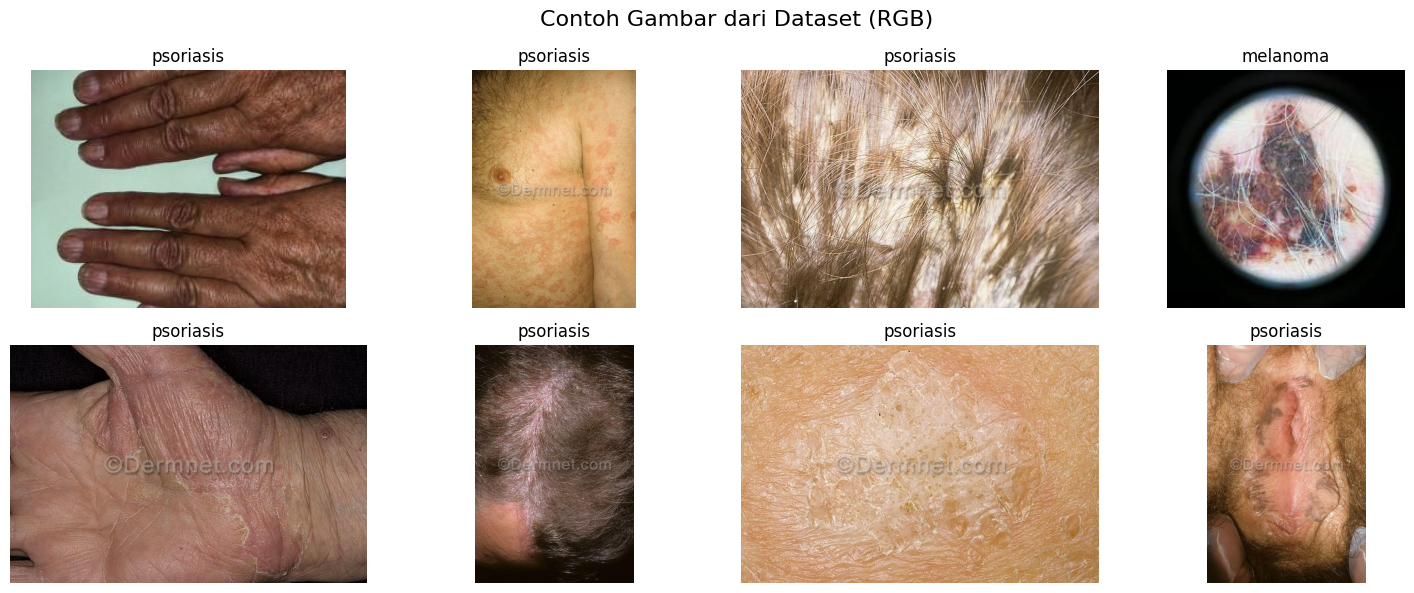

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path ke folder dataset RGB
dataset_dir = '/content/drive/MyDrive/dataset_kulit/rgb_dataset'
labels = ['melanoma', 'psoriasis']
num_images = 8  # jumlah gambar yang ingin ditampilkan

# Ambil daftar semua gambar beserta labelnya
all_images = []
for label in labels:
    folder = os.path.join(dataset_dir, label)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for f in files:
        all_images.append((os.path.join(folder, f), label))

# Pilih gambar secara acak
sample_images = random.sample(all_images, min(num_images, len(all_images)))

# Visualisasi
plt.figure(figsize=(15, 6))
for idx, (img_path, label) in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Dataset (RGB)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

def count_images_and_plot(base_dir, labels, title, output_path=None):
    base = Path(base_dir)
    counts = []

    for label in labels:
        folder = base / label
        total = len(list(folder.glob('*.[jJpP][pPnN]*[gG]')))  # *.jpg, *.jpeg, *.png
        counts.append((label, total))
        print(f"{label:<10}: {total:>5} file")

    # Buat grafik
    labels_plot = [lbl for lbl, _ in counts]
    values_plot = [val for _, val in counts]
    colors = ['darkred', 'orange']

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels_plot, values_plot, color=colors)
    for bar in bars:
        y = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, y + 20, f"{y:,}", ha='center', fontsize=11)

    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.tight_layout()

    if output_path:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, dpi=300)
        print(f"Grafik disimpan di: {output_path}")

    plt.show()

melanoma  :   656 file
psoriasis :  1504 file
Grafik disimpan di: /content/drive/MyDrive/dataset_kulit/logs/distribusi_rgb_dataset.png


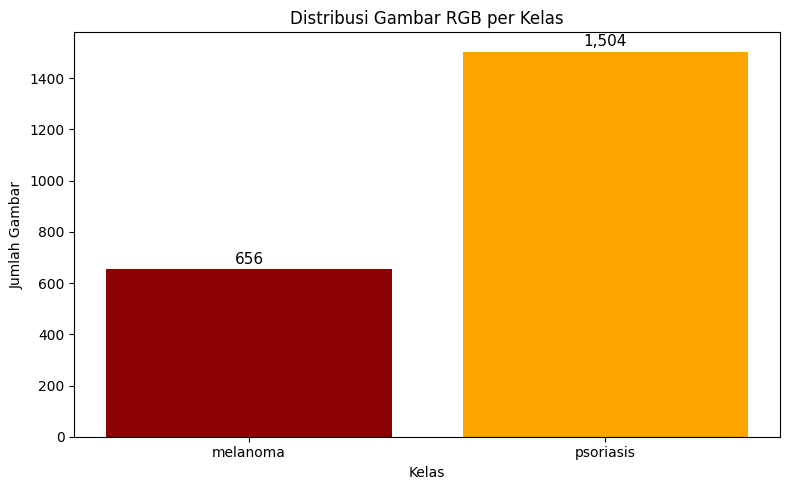

In [ ]:
count_images_and_plot(
    base_dir='/content/drive/MyDrive/dataset_kulit/rgb_dataset',
    labels=['melanoma', 'psoriasis'],
    title='Distribusi Gambar RGB per Kelas',
    output_path='/content/drive/MyDrive/dataset_kulit/logs/distribusi_rgb_dataset.png'
)

In [ ]:
import os

def count_images(folder):

    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        return 0

    return len([
        f for f in os.listdir(folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png')) and os.path.isfile(os.path.join(folder, f))
    ])

# Path ke dataset yang SUDAH dibersihkan dari gambar buram
base_path = '/content/drive/MyDrive/dataset_kulit/rgb_dataset'
melanoma_path = os.path.join(base_path, 'melanoma')
psoriasis_path = os.path.join(base_path, 'psoriasis')

# Hitung gambar
melanoma_count = count_images(melanoma_path)
psoriasis_count = count_images(psoriasis_path)

# Tampilkan hasil
print("\nJumlah Gambar per Kelas (Setelah Pembersihan)")
print("=" * 50)
print(f"Melanoma  : {melanoma_count:,} file")
print(f"Psoriasis : {psoriasis_count:,} file")


Jumlah Gambar per Kelas (Setelah Pembersihan)
Melanoma  : 656 file
Psoriasis : 1,504 file


In [ ]:
import os
import shutil
import random

def undersample_minority_to_match_major(source_dir, target_dir, label_fixed, label_to_trim):
    # Path sumber
    fixed_src = os.path.join(source_dir, label_fixed)
    trim_src = os.path.join(source_dir, label_to_trim)

    # Path tujuan
    fixed_dst = os.path.join(target_dir, label_fixed)
    trim_dst = os.path.join(target_dir, label_to_trim)

    # Bersihkan folder tujuan
    for path in [fixed_dst, trim_dst]:
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path, exist_ok=True)

    # Ambil file
    fixed_files = [f for f in os.listdir(fixed_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    trim_files = [f for f in os.listdir(trim_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Target jumlah
    n_target = len(fixed_files)

    if len(trim_files) < n_target:
        print("Tidak bisa undersample, jumlah minor lebih kecil dari mayor.")
        return

    # Acak dan ambil sample dari folder yang perlu dipangkas
    random.shuffle(trim_files)
    sampled_trim_files = trim_files[:n_target]

    # Salin file dari folder tetap (melanoma)
    for fname in fixed_files:
        shutil.copy(os.path.join(fixed_src, fname), os.path.join(fixed_dst, fname))

    # Salin hasil undersample dari psoriasis
    for fname in sampled_trim_files:
        shutil.copy(os.path.join(trim_src, fname), os.path.join(trim_dst, fname))

    # Ringkasan
    print("\nUNDERSAMPLING SELESAI (tanpa duplikasi)")
    print("=" * 45)
    print(f"{label_fixed:<12} : {len(fixed_files):>4} file (dibiarkan tetap)")
    print(f"{label_to_trim:<12} : {len(sampled_trim_files):>4} file (dipangkas dari {len(trim_files)})")
    print("=" * 45)

In [ ]:
undersample_minority_to_match_major(
    source_dir='/content/drive/MyDrive/dataset_kulit/rgb_dataset',
    target_dir='/content/drive/MyDrive/dataset_kulit/balanced_dataset',
    label_fixed='melanoma',
    label_to_trim='psoriasis'
)


UNDERSAMPLING SELESAI (tanpa duplikasi)
melanoma     :  656 file (dibiarkan tetap)
psoriasis    :  656 file (dipangkas dari 1504)


Gambar disimpan di: /content/drive/MyDrive/dataset_kulit/visual_balanced_distribution.png


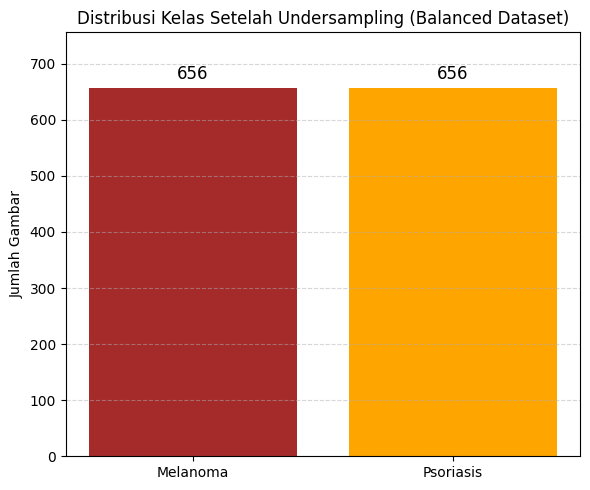

In [ ]:
import os
import matplotlib.pyplot as plt

# Path folder dataset seimbang di Google Drive
base_path = '/content/drive/MyDrive/dataset_kulit/balanced_dataset'
mel_path = os.path.join(base_path, 'melanoma')
psor_path = os.path.join(base_path, 'psoriasis')

# Hitung jumlah gambar
mel_count = len([f for f in os.listdir(mel_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
psor_count = len([f for f in os.listdir(psor_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Siapkan data plot
labels = ['Melanoma', 'Psoriasis']
counts = [mel_count, psor_count]

# Plot bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=['brown', 'orange'])

# Tambahkan label angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height),
             ha='center', va='bottom', fontsize=12)

plt.title("Distribusi Kelas Setelah Undersampling (Balanced Dataset)")
plt.ylabel("Jumlah Gambar")
plt.ylim(0, max(counts) + 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Simpan hasil ke file PNG
output_path = '/content/drive/MyDrive/dataset_kulit/visual_balanced_distribution.png'
plt.savefig(output_path)
print(f"Gambar disimpan di: {output_path}")

# Tampilkan juga
plt.show()

Gambar histogram disimpan di: /content/drive/MyDrive/dataset_kulit/visual_histogram_balanced.png


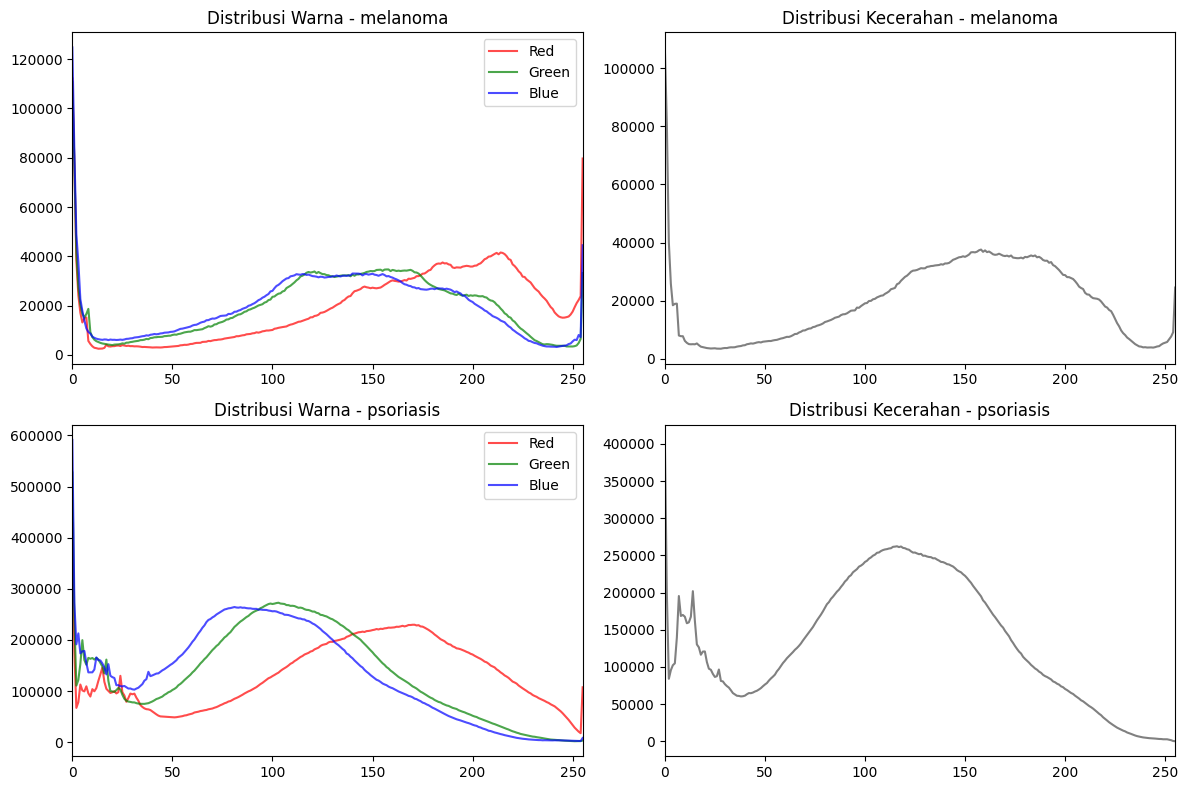

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Path dataset di Google Drive
dataset_path = '/content/drive/MyDrive/dataset_kulit/balanced_dataset'

# Ambil hanya folder kelas yang valid
classes = sorted([
    name for name in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, name)) and not name.startswith('.')
])

# Fungsi untuk menghitung histogram warna dan kecerahan
def analyze_image_histograms(class_path, num_samples=100):
    red_hist, green_hist, blue_hist, brightness_hist = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

    for fname in files:
        img_path = os.path.join(class_path, fname)
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Gagal membuka gambar: {img_path} — {e}")
            continue

        img_array = np.array(img)

        red_channel = img_array[:, :, 0]
        green_channel = img_array[:, :, 1]
        blue_channel = img_array[:, :, 2]
        brightness = np.mean(img_array, axis=2).astype(np.uint8)

        for channel, hist in zip([red_channel, green_channel, blue_channel, brightness],
                                 [red_hist, green_hist, blue_hist, brightness_hist]):
            hist += np.histogram(channel, bins=256, range=(0, 255))[0]

    return red_hist, green_hist, blue_hist, brightness_hist

# Plot histogram warna dan kecerahan
fig, axs = plt.subplots(len(classes), 2, figsize=(12, 4 * len(classes)))

for idx, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    r, g, b, brightness = analyze_image_histograms(class_path, num_samples=100)

    axs[idx, 0].plot(r, color='red', label='Red', alpha=0.7)
    axs[idx, 0].plot(g, color='green', label='Green', alpha=0.7)
    axs[idx, 0].plot(b, color='blue', label='Blue', alpha=0.7)
    axs[idx, 0].set_title(f'Distribusi Warna - {cls}')
    axs[idx, 0].legend()
    axs[idx, 0].set_xlim([0, 255])

    axs[idx, 1].plot(brightness, color='gray')
    axs[idx, 1].set_title(f'Distribusi Kecerahan - {cls}')
    axs[idx, 1].set_xlim([0, 255])

plt.tight_layout()

# Simpan sebagai PNG di Google Drive
output_path = '/content/drive/MyDrive/dataset_kulit/visual_histogram_balanced.png'
plt.savefig(output_path)
print(f"Gambar histogram disimpan di: {output_path}")

plt.show()

In [ ]:
import os
from PIL import Image

# Path dataset di Google Drive
input_root = '/content/drive/MyDrive/dataset_kulit/balanced_dataset'      # Folder input (balanced)
output_root = '/content/drive/MyDrive/dataset_kulit/resized_dataset'      # Folder output (resized)
target_size = (224, 224)                                                  # Ukuran target gambar

# Membuat folder tujuan untuk masing-masing kelas
os.makedirs(output_root, exist_ok=True)
for label in os.listdir(input_root):
    os.makedirs(os.path.join(output_root, label), exist_ok=True)

# Fungsi untuk resize gambar
def resize_images(source_dir, dest_dir, size=(224, 224)):
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            source_path = os.path.join(source_dir, filename)
            dest_path = os.path.join(dest_dir, filename)
            try:
                with Image.open(source_path) as img:
                    img = img.convert('RGB')      # Pastikan RGB
                    img = img.resize(size)        # Resize gambar
                    img.save(dest_path)           # Simpan hasil resize
            except Exception as e:
                print(f"Gagal memproses {filename}: {e}")

# Jalankan proses resize
for label in os.listdir(input_root):
    source_folder = os.path.join(input_root, label)
    dest_folder = os.path.join(output_root, label)
    resize_images(source_folder, dest_folder)

print("Proses resize selesai. Semua gambar disimpan di folder 'resized_dataset'.")

Proses resize selesai. Semua gambar disimpan di folder 'resized_dataset'.


In [ ]:
import os

# Path ke folder dataset yang sudah di-resize
dataset_path = '/content/drive/MyDrive/dataset_kulit/resized_dataset'

# Inisialisasi label (folder dalam resized_dataset)
labels = os.listdir(dataset_path)

# Hitung dan tampilkan jumlah file gambar untuk tiap label
print("Jumlah gambar per label di resized_dataset:")
print("=" * 50)

total = 0
for label in labels:
    label_folder = os.path.join(dataset_path, label)

    if not os.path.isdir(label_folder):
        continue  # Lewati jika bukan folder

    count = len([
        f for f in os.listdir(label_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png')) and os.path.isfile(os.path.join(label_folder, f))
    ])

    print(f"  - {label:<10}: {count} file")
    total += count

print(f"\nTotal semua gambar: {total} file")
print("=" * 50)

Jumlah gambar per label di resized_dataset:
  - melanoma  : 656 file
  - psoriasis : 1493 file

Total semua gambar: 2149 file


In [ ]:
import os
from PIL import Image

def check_image_sizes(folder_path, expected_size=(224, 224)):
    masalah_ditemukan = False
    for label in os.listdir(folder_path):
        folder = os.path.join(folder_path, label)
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder, fname)
                try:
                    with Image.open(img_path) as img:
                        if img.size != expected_size:
                            print(f"{fname} di folder {label} ukurannya {img.size}")
                            masalah_ditemukan = True
                except Exception as e:
                    print(f"Gagal membaca {img_path}: {e}")
                    masalah_ditemukan = True
    if not masalah_ditemukan:
        print("Semua gambar berukuran 224x224")

# Jalankan pemeriksaan
check_image_sizes('/content/drive/MyDrive/dataset_kulit/resized_dataset')

Semua gambar berukuran 224x224


Gambar disimpan ke: /content/drive/MyDrive/dataset_kulit/sample_images.png


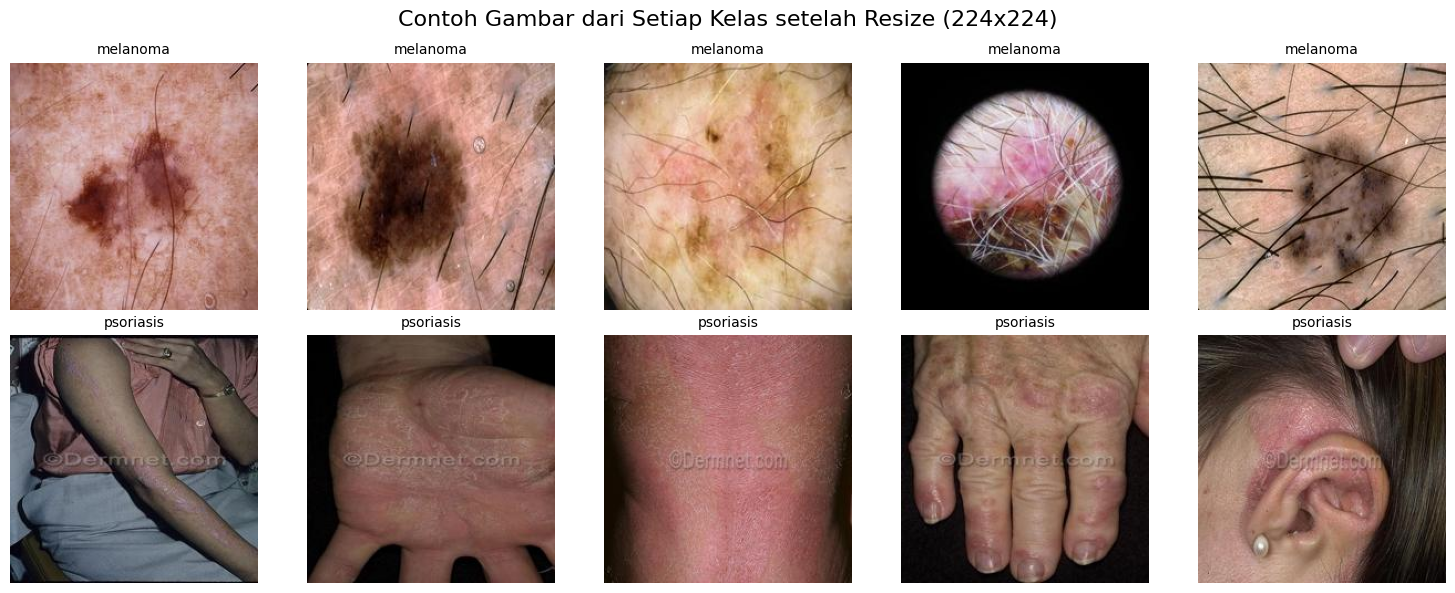

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_sample_images_per_class(folder_path, num_images_per_class=5, save_path=None):
    class_labels = sorted([
        label for label in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, label))
    ])

    total_classes = len(class_labels)
    plt.figure(figsize=(num_images_per_class * 3, total_classes * 3))

    image_index = 1
    for label in class_labels:
        class_folder = os.path.join(folder_path, label)
        files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Ambil sejumlah gambar acak dari setiap kelas
        sample_files = random.sample(files, min(num_images_per_class, len(files)))

        for fname in sample_files:
            img_path = os.path.join(class_folder, fname)
            try:
                img = Image.open(img_path)

                plt.subplot(total_classes, num_images_per_class, image_index)
                plt.imshow(img)
                plt.title(label, fontsize=10)
                plt.axis('off')
                image_index += 1
            except Exception as e:
                print(f"Gagal membuka gambar: {img_path} — {e}")

    plt.suptitle("Contoh Gambar dari Setiap Kelas setelah Resize (224x224)", fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Gambar disimpan ke: {save_path}")

    plt.show()

# Gunakan path folder hasil resize di Google Drive
resized_dataset_path = '/content/drive/MyDrive/dataset_kulit/resized_dataset'
save_output_path = '/content/drive/MyDrive/dataset_kulit/sample_images.png'

# Jalankan fungsi
show_sample_images_per_class(resized_dataset_path, num_images_per_class=5, save_path=save_output_path)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/drive/MyDrive/dataset_kulit/resized_dataset'

# Generator data pelatihan dengan augmentasi lengkap
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # rotasi ringan (aman untuk citra kulit)
    zoom_range=0.2,              # variasi zoom in/out
    width_shift_range=0.1,       # translasi horizontal kecil
    height_shift_range=0.1,      # translasi vertikal kecil
    horizontal_flip=True,        # flip horizontal untuk variasi orientasi
    brightness_range=[0.8, 1.2], # variasi pencahayaan (opsional)
    validation_split=0.2         # split 20% untuk validasi
)

# Generator data pelatihan (subset training)
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(224, 224),      # resize gambar jadi 224x224
    batch_size=32,
    class_mode='categorical',
    subset='training',           # ambil subset training
    shuffle=True                 # acak data setiap batch
)

# Generator data validasi (tanpa augmentasi, hanya rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generator data validasi (subset validation)
val_generator = val_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',         # ambil subset validation
    shuffle=False                # tidak diacak supaya evaluasi konsisten
)

Found 1720 images belonging to 2 classes.
Found 429 images belonging to 2 classes.


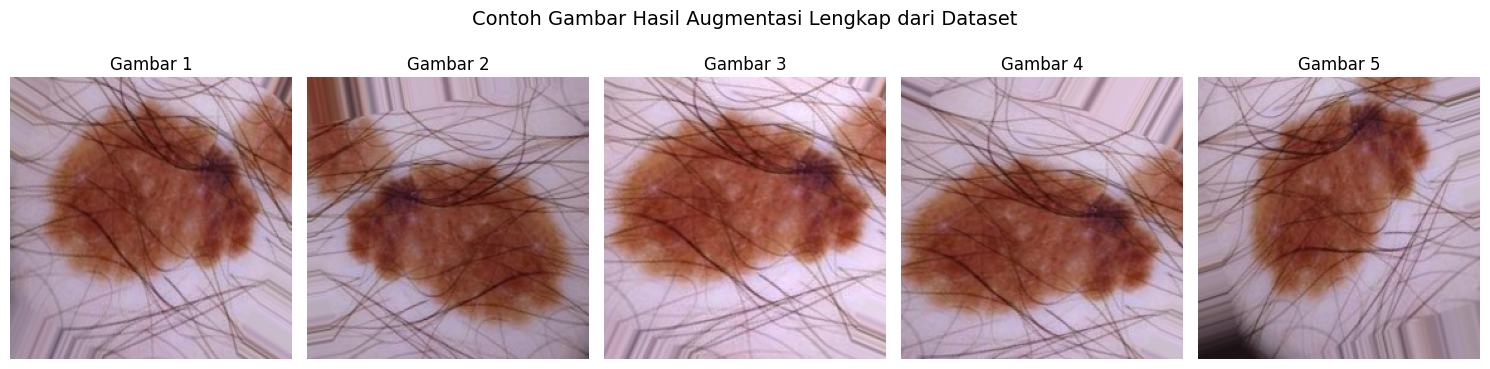

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Path dataset
dataset_path = '/content/drive/MyDrive/dataset_kulit/resized_dataset'

# Cari gambar pertama secara rekursif dari subfolder mana pun
first_image_path = None
for root, dirs, files in os.walk(dataset_path):
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        first_image_path = os.path.join(root, image_files[0])
        break

if first_image_path is None:
    raise ValueError("Tidak ditemukan file gambar dalam subfolder mana pun.")

# Load dan resize gambar ke (224, 224)
img = load_img(first_image_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Membuat batch dengan 1 gambar

# Definisikan ImageDataGenerator dengan augmentasi lengkap
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Buat iterator augmentasi gambar
aug_iter = datagen.flow(x, batch_size=1)

# Tampilkan 5 contoh hasil augmentasi
plt.figure(figsize=(15, 4))
for i in range(5):
    batch = next(aug_iter)
    image = batch[0]
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Gambar {i+1}")

plt.suptitle('Contoh Gambar Hasil Augmentasi Lengkap dari Dataset', fontsize=14)
plt.tight_layout()
plt.show()

# **SPLIT DATASET**

In [ ]:
import os
import shutil
import hashlib
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Setup path dan parameter
SOURCE_DIR = '/content/drive/MyDrive/dataset_kulit/resized_dataset'
DEST_DIR = '/content/drive/MyDrive/dataset_kulit/split_dataset'
CLASSES = ['melanoma', 'psoriasis']
RANDOM_SEED = 42
EXTENSIONS = ('.jpg', '.jpeg', '.png')

# Deduplication gambar identik
print("Mendeteksi dan menghapus gambar duplikat global...")

def get_image_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hash_map = defaultdict(list)
unique_images = {cls: [] for cls in CLASSES}

for label in CLASSES:
    class_dir = os.path.join(SOURCE_DIR, label)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(EXTENSIONS):
            fpath = os.path.join(class_dir, fname)
            hash_val = get_image_hash(fpath)
            if hash_val not in hash_map:
                hash_map[hash_val].append(fpath)
                unique_images[label].append(fpath)

print(f"Total gambar unik setelah deduplikasi: melanoma = {len(unique_images['melanoma'])}, psoriasis = {len(unique_images['psoriasis'])}")

# Balancing jumlah data per kelas
min_count = min(len(unique_images['melanoma']), len(unique_images['psoriasis']))
print(f"Menyamakan jumlah data ke {min_count} gambar per kelas...")

balanced_filepaths = []
balanced_labels = []

for label in CLASSES:
    sampled = random.sample(unique_images[label], min_count)
    balanced_filepaths.extend(sampled)
    balanced_labels.extend([label] * min_count)

# Split stratified train, val, test
print("Melakukan stratified split data train, val, dan test...")

X_train, X_temp, y_train, y_temp = train_test_split(
    balanced_filepaths, balanced_labels,
    test_size=0.4,
    stratify=balanced_labels,
    random_state=RANDOM_SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_SEED)

# Hapus folder tujuan lama jika ada
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
    print(f"Menghapus folder tujuan lama: {DEST_DIR}")

# Salin file ke folder baru sesuai split
def copy_data(filepaths, labels, subset):
    for src_path, label in zip(filepaths, labels):
        dest_folder = os.path.join(DEST_DIR, subset, label)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(src_path, os.path.join(dest_folder, os.path.basename(src_path)))

print("Menyalin file ke folder split_dataset/...")

copy_data(X_train, y_train, 'train')
copy_data(X_val, y_val, 'val')
copy_data(X_test, y_test, 'test')

# Cek jumlah file per split dan kelas
print("\nDistribusi jumlah gambar setelah split dan penyalinan:")
for split in ['train', 'val', 'test']:
    for label in CLASSES:
        folder = os.path.join(DEST_DIR, split, label)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(EXTENSIONS)])
        print(f"{split}/{label}: {count} gambar")

# Cek duplikat lintas split
print("\nMengecek duplikat lintas split dataset...")

hash_per_file = defaultdict(list)
for split in ['train', 'val', 'test']:
    for label in CLASSES:
        folder = os.path.join(DEST_DIR, split, label)
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            if fpath.lower().endswith(EXTENSIONS):
                h = get_image_hash(fpath)
                hash_per_file[h].append(fpath)

cross_split_dupes = [
    paths for paths in hash_per_file.values()
    if len(set(p.split(os.sep)[-3] for p in paths)) > 1
]

if not cross_split_dupes:
    print("Tidak ada duplikat lintas split. Dataset aman digunakan.")
else:
    print(f"Ditemukan {len(cross_split_dupes)} kelompok duplikat lintas split. Dataset TIDAK aman.")

Mendeteksi dan menghapus gambar duplikat global...
Total gambar unik setelah deduplikasi: melanoma = 656, psoriasis = 1493
Menyamakan jumlah data ke 656 gambar per kelas...
Melakukan stratified split data train, val, dan test...
Menghapus folder tujuan lama: /content/drive/MyDrive/dataset_kulit/split_dataset
Menyalin file ke folder split_dataset/...

Distribusi jumlah gambar setelah split dan penyalinan:
train/melanoma: 393 gambar
train/psoriasis: 394 gambar
val/melanoma: 131 gambar
val/psoriasis: 131 gambar
test/melanoma: 132 gambar
test/psoriasis: 131 gambar

Mengecek duplikat lintas split dataset...
Tidak ada duplikat lintas split. Dataset aman digunakan.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset'

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 787 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Found 263 images belonging to 2 classes.


Plot disimpan di: /content/drive/MyDrive/dataset_kulit/split_distribution.png


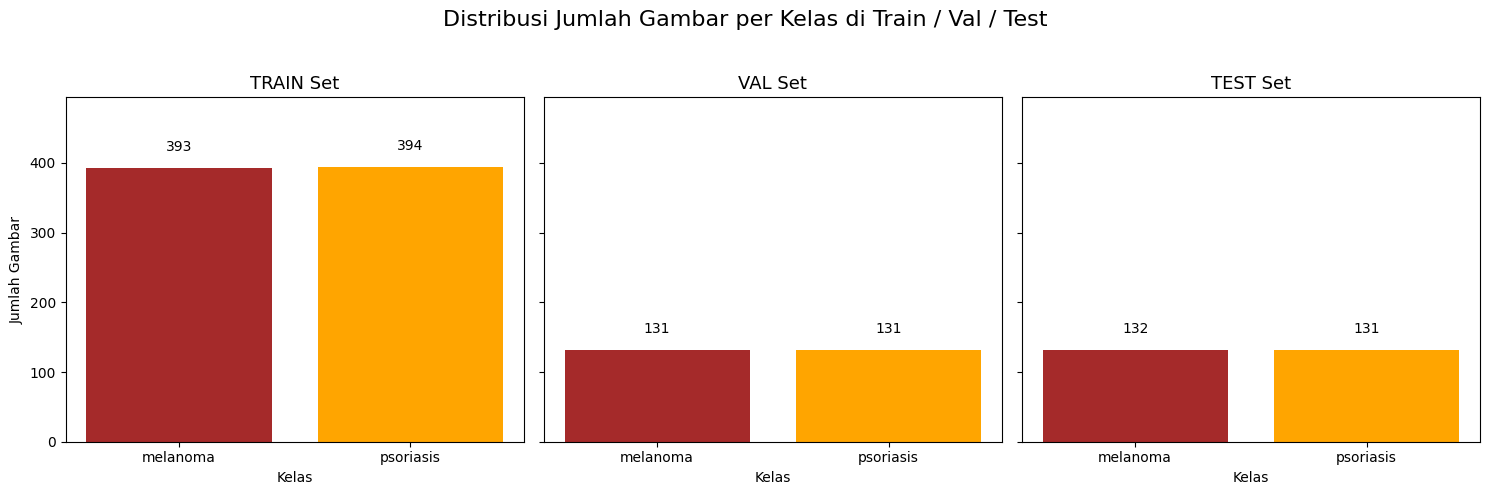

In [ ]:
import os
import matplotlib.pyplot as plt

# Lokasi dataset di Google Drive
base_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset'
splits = ['train', 'val', 'test']
labels = ['melanoma', 'psoriasis']
colors = ['brown', 'orange']

# Hitung jumlah file per kelas
split_counts = {}
for split in splits:
    split_counts[split] = {}
    for label in labels:
        class_dir = os.path.join(base_dir, split, label)
        if os.path.exists(class_dir):
            count = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            split_counts[split][label] = count
        else:
            split_counts[split][label] = 0

# Nilai maksimum untuk y-axis
max_count = max(
    max(split_counts[split][label] for label in labels)
    for split in splits
) + 100

# Buat plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for idx, split in enumerate(splits):
    counts = [split_counts[split][label] for label in labels]
    bars = axs[idx].bar(labels, counts, color=colors)

    axs[idx].set_title(f"{split.upper()} Set", fontsize=13)
    axs[idx].set_xlabel("Kelas")
    axs[idx].set_ylim(0, max_count)

    if idx == 0:
        axs[idx].set_ylabel("Jumlah Gambar")

    # Tambahkan angka di atas bar
    for bar in bars:
        height = bar.get_height()
        axs[idx].text(
            bar.get_x() + bar.get_width() / 2,
            height + 20,
            str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.suptitle("Distribusi Jumlah Gambar per Kelas di Train / Val / Test", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Simpan sebagai PNG ke Google Drive
output_path = '/content/drive/MyDrive/dataset_kulit/split_distribution.png'
plt.savefig(output_path, dpi=300)
print(f"Plot disimpan di: {output_path}")

plt.show()

Gambar disimpan ke: /content/drive/MyDrive/dataset_kulit/sample_melanoma_train.png


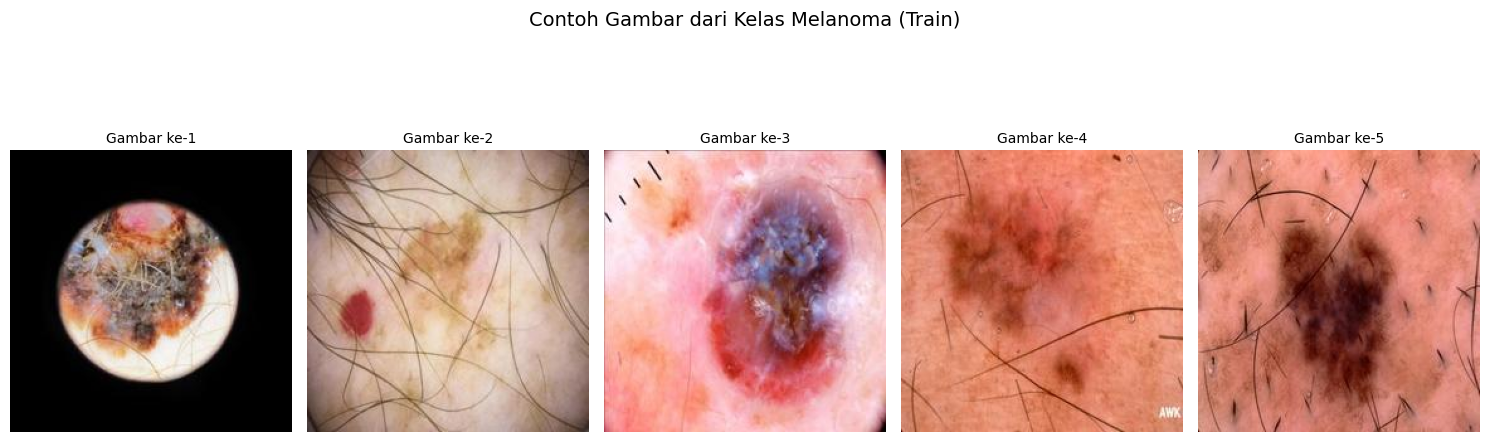

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path folder melanoma di split train (ubah sesuai struktur dataset di Colab)
folder_path = '/content/drive/MyDrive/dataset_kulit/split_dataset/train/melanoma'

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Cek apakah gambar tersedia
if not image_files:
    print(f"Tidak ditemukan gambar di folder: {folder_path}")
else:
    num_images = min(5, len(image_files))        # Tampilkan max 5 gambar
    target_size = (224, 224)

    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Normalisasi piksel

            plt.subplot(1, num_images, i + 1)
            plt.imshow(img_array)
            plt.title(f"Gambar ke-{i+1}", fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Gagal memuat gambar {img_path}: {e}")

    plt.suptitle("Contoh Gambar dari Kelas Melanoma (Train)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    # Simpan hasil sebagai PNG ke Google Drive
    output_path = '/content/drive/MyDrive/dataset_kulit/sample_melanoma_train.png'
    plt.savefig(output_path, dpi=300)
    print(f"Gambar disimpan ke: {output_path}")

    plt.show()

Distribusi data per subset dan kelas:
  Subset      Kelas  Jumlah
0  train   melanoma     393
1  train  psoriasis     394
2    val  psoriasis     131
3    val   melanoma     131
4   test   melanoma     132
5   test  psoriasis     131

Total Gambar:
Train: 787
Validation: 262
Test: 263

Rasio Persentase:
Train: 60.0%
Val:   20.0%
Test:  20.0%

Gambar disimpan di: /content/drive/MyDrive/dataset_kulit/distribusi_dataset.png


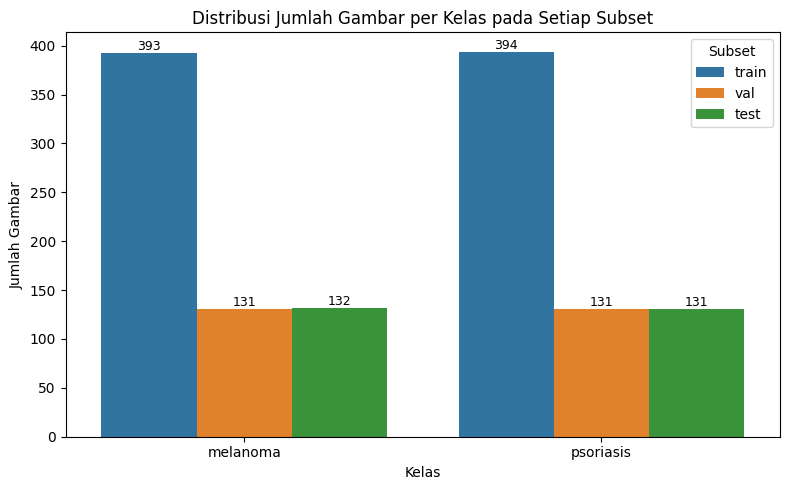

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path dataset (ganti sesuai lokasi kamu)
base_path = '/content/drive/MyDrive/dataset_kulit/split_dataset'

# Inisialisasi struktur distribusi data
data_distribution = {'train': {}, 'val': {}, 'test': {}}

# Loop subset dan kelas
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(base_path, subset)
    if not os.path.exists(subset_path):
        print(f"Folder tidak ditemukan: {subset_path}")
        continue

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        image_count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        data_distribution[subset][class_name] = image_count

# Buat DataFrame dari distribusi
data_list = []
for subset, class_counts in data_distribution.items():
    for class_name, count in class_counts.items():
        data_list.append({"Subset": subset, "Kelas": class_name, "Jumlah": count})
df_distribution = pd.DataFrame(data_list)

# Tampilkan distribusi
print("Distribusi data per subset dan kelas:")
print(df_distribution)

# Hitung total dan rasio
train_total = sum(data_distribution['train'].values())
val_total = sum(data_distribution['val'].values())
test_total = sum(data_distribution['test'].values())
total = train_total + val_total + test_total

train_ratio = round(train_total / total, 3) if total > 0 else 0
val_ratio = round(val_total / total, 3) if total > 0 else 0
test_ratio = round(test_total / total, 3) if total > 0 else 0

print("\nTotal Gambar:")
print("Train:", train_total)
print("Validation:", val_total)
print("Test:", test_total)

print("\nRasio Persentase:")
print(f"Train: {train_ratio * 100:.1f}%")
print(f"Val:   {val_ratio * 100:.1f}%")
print(f"Test:  {test_ratio * 100:.1f}%")

# Visualisasi distribusi
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=df_distribution, x="Kelas", y="Jumlah", hue="Subset")

# Tambahkan label jumlah di atas bar
for p in barplot.patches:
    height = int(p.get_height())
    if height > 0:
        barplot.annotate(f'{height}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, color='black')

plt.title("Distribusi Jumlah Gambar per Kelas pada Setiap Subset")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas")
plt.tight_layout()

# Simpan sebagai PNG
output_path = '/content/drive/MyDrive/dataset_kulit/distribusi_dataset.png'
plt.savefig(output_path, dpi=300)
print(f"\nGambar disimpan di: {output_path}")

plt.show()

In [ ]:
import os

train_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset/train'
val_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset/val'
test_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset/test'

for phase, path in [('Train', train_dir), ('Val', val_dir), ('Test', test_dir)]:
    print(f'\n{phase.upper()} DATA:')
    if not os.path.exists(path):
        print(f'  - Folder tidak ditemukan: {path}')
        continue
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f'  - {cls}: {count} gambar')


TRAIN DATA:
  - melanoma: 393 gambar
  - psoriasis: 394 gambar

VAL DATA:
  - psoriasis: 131 gambar
  - melanoma: 131 gambar

TEST DATA:
  - melanoma: 132 gambar
  - psoriasis: 131 gambar


# **TRAINING MODEL MODEL VGG16**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Load dataset dari folder split
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# Augmentasi khusus hanya untuk training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Terapkan augmentasi dan preprocessing ke train
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Terapkan hanya preprocess_input ke val/test
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Optimisasi pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 787 files belonging to 2 classes.
Found 262 files belonging to 2 classes.
Found 263 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Tambahkan classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

# Buat dan compile model
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Path direktori penyimpanan model dan log di Google Drive atau Linux/macOS
base_path = '/content/drive/MyDrive/dataset_kulit'
model_dir = os.path.join(base_path, 'models')
log_dir = os.path.join(base_path, 'logs')

# Buat folder jika belum ada
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Konfigurasi Callback
callbacks = [
    EarlyStopping(
        monitor='val_loss',       # bisa juga 'val_accuracy'
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_vgg16_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    CSVLogger(os.path.join(log_dir, 'vgg16_training_log.csv'))
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5384 - loss: 2.0699
Epoch 1: val_accuracy improved from -inf to 0.74809, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 985ms/step - accuracy: 0.5412 - loss: 2.0532 - val_accuracy: 0.7481 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7821 - loss: 0.7400
Epoch 2: val_accuracy improved from 0.74809 to 0.87023, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.7821 - loss: 0.7405 - val_accuracy: 0.8702 - val_loss: 0.4031 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8088 - loss: 0.6197
Epoch 3: val_accuracy improved from 0.87023 to 0.90458, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.8098 - loss: 0.6189 - val_accuracy: 0.9046 - val_loss: 0.3157 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8408 - loss: 0.4945
Epoch 4: val_accuracy improved from 0.90458 to 0.93893, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.8414 - loss: 0.4925 - val_accuracy: 0.9389 - val_loss: 0.2775 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8595 - loss: 0.3929
Epoch 5: val_accuracy improved from 0.93893 to 0.94275, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8605 - loss: 0.3917 - val_accuracy: 0.9427 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9026 - loss: 0.3101
Epoch 6: val_accuracy improved from 0.94275 to 0.94656, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - accuracy: 0.9025 - loss: 0.3087 - val_accuracy: 0.9466 - val_loss: 0.2475 - learning_rate: 1.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9154 - loss: 0.2338
Epoch 7: val_accuracy did not improve from 0.94656
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9155 - loss: 0.2341 - val_accuracy: 0.9466 - val_loss: 0.2328 - learning_rate: 1.0000e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9296 - loss: 0.2122
Epoch 8: val_accuracy improved from 0.94656 to 0.96565, saving model to /content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.9297 - loss: 0.2123 - val_accuracy: 0.9656 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9296 - loss: 0.1946
Epoch 9: val_accuracy did not improve from 0.96565
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9297 - loss: 0.1941 - val_accuracy: 0.9656 - val_loss: 0.2201 - learning_rate: 1.0000e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9435 - loss: 0.1702
Epoch 10: val_accuracy did not improve from 0.96565
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9430 - loss: 0.1716 - val_accuracy: 0.9656 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9329 - loss: 0.1895
Epoch 11: val_accuracy did not improve from 0.96565
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9333 - loss: 0.1892 - val_accuracy: 0.9618 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epo

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9486 - loss: 0.1458 - val_accuracy: 0.9695 - val_loss: 0.2076 - learning_rate: 1.0000e-04
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9456 - loss: 0.1834
Epoch 14: val_accuracy did not improve from 0.96947
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.9462 - loss: 0.1811 - val_accuracy: 0.9695 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9665 - loss: 0.0900
Epoch 15: val_accuracy did not improve from 0.96947
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9663 - loss: 0.0904 - val_accuracy: 0.9695 - val_loss: 0.2111 - learning_rate: 1.0000e-04
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9591 - loss: 0.1020
Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 16: val_accuracy did not improve from 0.96947
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.9593 - loss: 0

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9653 - loss: 0.1016 - val_accuracy: 0.9733 - val_loss: 0.1957 - learning_rate: 5.0000e-05
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9782 - loss: 0.0792
Epoch 24: val_accuracy did not improve from 0.97328
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.9782 - loss: 0.0789 - val_accuracy: 0.9695 - val_loss: 0.1981 - learning_rate: 5.0000e-05
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9736 - loss: 0.0628
Epoch 25: val_accuracy did not improve from 0.97328
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.9736 - loss: 0.0628 - val_accuracy: 0.9695 - val_loss: 0.2010 - learning_rate: 5.0000e-05
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9649 - loss: 0.0816
Epoch 26: val_accuracy did not improve from 0.97328
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9649 - loss: 0.0816 - val_accuracy: 0.9733 - val_loss: 0.1940 - learning_rate: 5.0000e-05
Epo

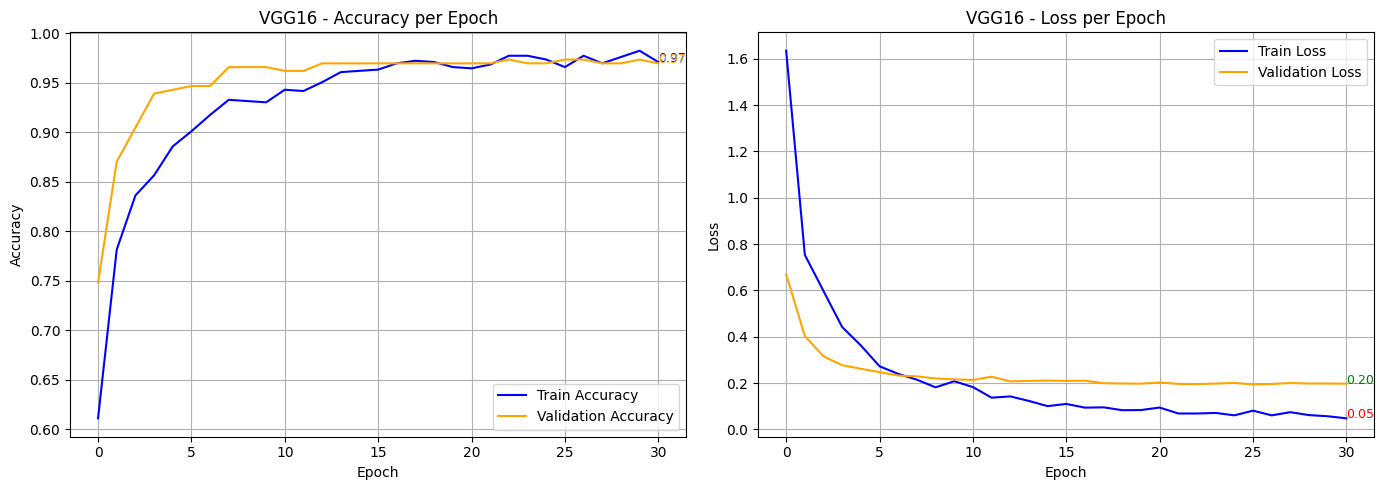

Plot disimpan di: /content/drive/MyDrive/dataset_kulit/logs/vgg16_training_plot.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path ke file log dan lokasi simpan plot
csv_log_path = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_training_log.csv'
plot_save_path = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_training_plot.png'

# Pastikan folder log tersedia
os.makedirs(os.path.dirname(plot_save_path), exist_ok=True)

# Baca log training
log_data = pd.read_csv(csv_log_path)

# Inisialisasi figure
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(log_data['accuracy'], label='Train Accuracy', color='blue')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy', color='orange')

# Anotasi akhir
last_epoch = len(log_data) - 1
plt.text(last_epoch, log_data['accuracy'][last_epoch], f"{log_data['accuracy'][last_epoch]:.2f}", color='blue', fontsize=9)
plt.text(last_epoch, log_data['val_accuracy'][last_epoch], f"{log_data['val_accuracy'][last_epoch]:.2f}", color='orange', fontsize=9)

plt.title('VGG16 - Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(log_data['loss'], label='Train Loss', color='blue')
plt.plot(log_data['val_loss'], label='Validation Loss', color='orange')

plt.text(last_epoch, log_data['loss'][last_epoch], f"{log_data['loss'][last_epoch]:.2f}", color='red', fontsize=9)
plt.text(last_epoch, log_data['val_loss'][last_epoch], f"{log_data['val_loss'][last_epoch]:.2f}", color='green', fontsize=9)

plt.title('VGG16 - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tata letak dan simpan
plt.tight_layout()
plt.savefig(plot_save_path, dpi=300)
plt.show()

print(f"Plot disimpan di: {plot_save_path}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

# PATHS
model_path = '/content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5'
test_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset/test'

# LOAD MODEL VGG16 YANG TERBAIK
model = load_model(model_path)
print("Model VGG16 terbaik berhasil dimuat.")

# LOAD TEST DATASET
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# PREPROCESSING SESUAI VGG16
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
print("Dataset test berhasil dimuat dan diproses.")

Model VGG16 terbaik berhasil dimuat.
Found 263 files belonging to 2 classes.
Dataset test berhasil dimuat dan diproses.


# **EVALUASI MODEL VGG16**

In [ ]:
# Evaluasi model di dataset test
test_loss, test_accuracy = model.evaluate(test_ds)

# Tampilkan hasil evaluasi
print("\nHASIL EVALUASI VGG16 DI TEST SET")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss     : {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - accuracy: 0.9756 - loss: 0.0825

HASIL EVALUASI VGG16 DI TEST SET
Test Accuracy : 0.9810
Test Loss     : 0.0700


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

# Ambil label asli dan prediksi dari test_ds (yang sudah dipreprocess)
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Ambil class names dari test folder asli (tanpa augmentasi)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
class_names = raw_test_ds.class_names

# Hitung classification report sebagai dictionary
report_dict = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    output_dict=True
)

# Ubah ke DataFrame lalu simpan ke CSV
report_df = pd.DataFrame(report_dict).transpose()

save_path = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_classification_report.csv'
report_df.to_csv(save_path, index=True)

# Tampilkan di terminal
print("\nClassification Report (VGG16 on Test Set):")
print(report_df.round(4))  # 4 digit presisi agar rapi
print(f"\nLaporan disimpan ke: {save_path}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step
Found 263 files belonging to 2 classes.

Classification Report (VGG16 on Test Set):
              precision  recall  f1-score  support
melanoma         0.9847  0.9773     0.981  132.000
psoriasis        0.9773  0.9847     0.981  131.000
accuracy         0.9810  0.9810     0.981    0.981
macro avg        0.9810  0.9810     0.981  263.000
weighted avg     0.9810  0.9810     0.981  263.000

Laporan disimpan ke: /content/drive/MyDrive/dataset_kulit/logs/vgg16_classification_report.csv


Found 263 files belonging to 2 classes.


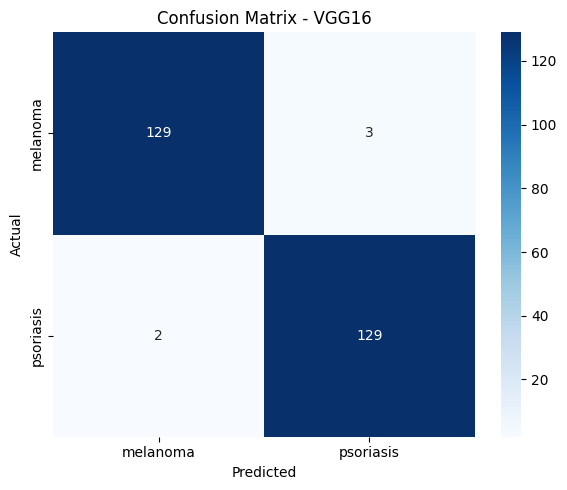

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gunakan prediksi dan label aktual dari test set
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Ambil nama kelas
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
class_names = raw_test_ds.class_names

# Visualisasi Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Simpan gambar matrix
plt.savefig('/content/drive/MyDrive/dataset_kulit/logs/vgg16_confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
if len(class_names) == 2:
    tn, fp, fn, tp = cm.ravel()
    print("\nRincian Confusion Matrix:")
    print(f"True Positive  (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative  (TN): {tn}")
else:
    print("TP-FP-FN-TN hanya berlaku untuk klasifikasi biner.")


Rincian Confusion Matrix:
True Positive  (TP): 129
False Positive (FP): 3
False Negative (FN): 2
True Negative  (TN): 129


# **MENYIAPKAN DATA UNTUK EFFNETB0**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Load dataset dari folder split
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# Augmentasi khusus hanya untuk training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Terapkan augmentasi dan preprocessing ke train
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Terapkan hanya preprocess_input ke val/test
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Optimisasi pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 787 files belonging to 2 classes.
Found 262 files belonging to 2 classes.
Found 263 files belonging to 2 classes.


# **TRAINING MODEL MODEL EFFICIENETB0**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load base EfficientNetB0 model (tanpa FC/top)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze seluruh layer awal
base_model.trainable = False

# Tambahkan classifier kustom
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)  # Output 2 kelas (kelas 0 & 1)

# Bangun model akhir
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan arsitektur
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Path direktori untuk menyimpan model dan log di Google Drive atau lokal Linux
base_path = '/content/drive/MyDrive/dataset_kulit'
model_dir = os.path.join(base_path, 'models')
log_dir = os.path.join(base_path, 'logs')

# Buat folder jika belum ada
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Konfigurasi Callback khusus untuk EfficientNetB0
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_efficientnetb0_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    CSVLogger(os.path.join(log_dir, 'efficientnetb0_training_log.csv'))
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6955 - loss: 0.5773
Epoch 1: val_accuracy improved from -inf to 0.94275, saving model to /content/drive/MyDrive/dataset_kulit/models/best_efficientnetb0_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6988 - loss: 0.5739 - val_accuracy: 0.9427 - val_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9241 - loss: 0.2925
Epoch 2: val_accuracy improved from 0.94275 to 0.97328, saving model to /content/drive/MyDrive/dataset_kulit/models/best_efficientnetb0_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9248 - loss: 0.2910 - val_accuracy: 0.9733 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9541 - loss: 0.1818
Epoch 3: val_accuracy improved from 0.97328 to 0.97710, saving model to /content/drive/MyDrive/dataset_kulit/models/best_efficientnetb0_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9539 - loss: 0.1816 - val_accuracy: 0.9771 - val_loss: 0.1503 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9589 - loss: 0.1321
Epoch 4: val_accuracy did not improve from 0.97710
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9588 - loss: 0.1325 - val_accuracy: 0.9771 - val_loss: 0.1319 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9608 - loss: 0.1095
Epoch 5: val_accuracy did not improve from 0.97710
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9610 - loss: 0.1095 - val_accuracy: 0.9771 - val_loss: 0.1194 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9570 - loss: 0.1253
Epoch 6: val_accuracy did not improve from 0.97710
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9573 - loss: 0.1245 - val_accuracy: 0.9771 - val_loss: 0.1122 - learning_rate: 1.0000e-04
Epoch 7/50
25/25

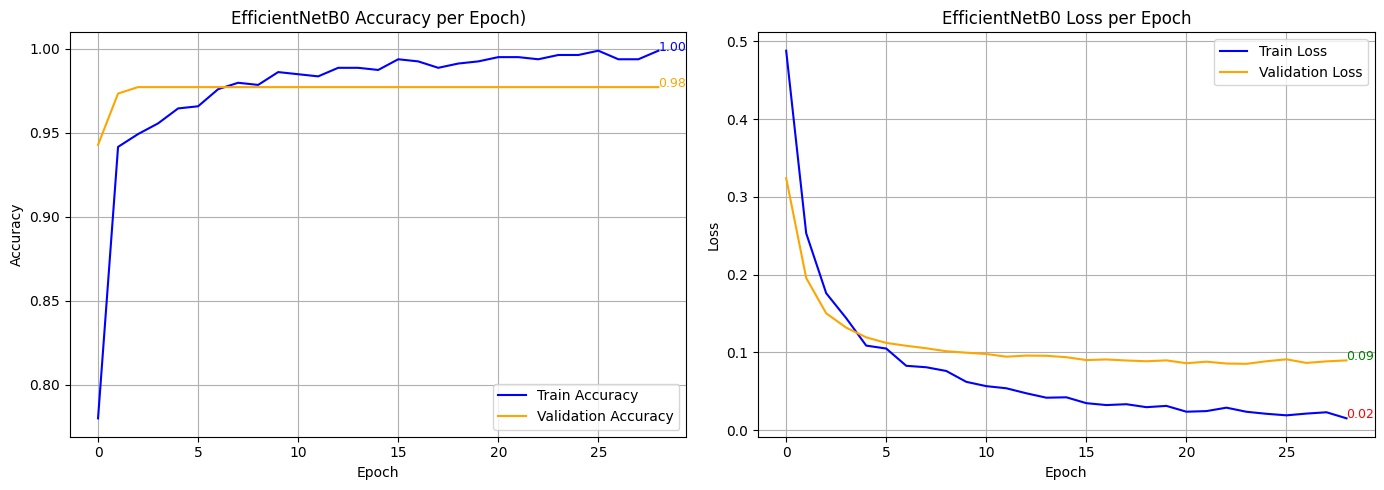

Plot disimpan di: /content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_training_plot.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path ke file log dan lokasi simpan plot
csv_log_path = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_training_log.csv'
plot_save_path = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_training_plot.png'

# Pastikan folder log tersedia
os.makedirs(os.path.dirname(plot_save_path), exist_ok=True)

# Baca log training
log_data = pd.read_csv(csv_log_path)

# Inisialisasi figure
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(log_data['accuracy'], label='Train Accuracy', color='blue')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy', color='orange')

# Anotasi akhir
last_epoch = len(log_data) - 1
plt.text(last_epoch, log_data['accuracy'][last_epoch], f"{log_data['accuracy'][last_epoch]:.2f}", color='blue', fontsize=9)
plt.text(last_epoch, log_data['val_accuracy'][last_epoch], f"{log_data['val_accuracy'][last_epoch]:.2f}", color='orange', fontsize=9)

plt.title('EfficientNetB0 Accuracy per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(log_data['loss'], label='Train Loss', color='blue')
plt.plot(log_data['val_loss'], label='Validation Loss', color='orange')

plt.text(last_epoch, log_data['loss'][last_epoch], f"{log_data['loss'][last_epoch]:.2f}", color='red', fontsize=9)
plt.text(last_epoch, log_data['val_loss'][last_epoch], f"{log_data['val_loss'][last_epoch]:.2f}", color='green', fontsize=9)

plt.title('EfficientNetB0 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tata letak dan simpan
plt.tight_layout()
plt.savefig(plot_save_path, dpi=300)
plt.show()

print(f"Plot disimpan di: {plot_save_path}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# PATHS
model_path = '/content/drive/MyDrive/dataset_kulit/models/best_efficientnetb0_model.h5'
test_dir = '/content/drive/MyDrive/dataset_kulit/split_dataset/test'

# LOAD MODEL EfficientNetB0
model = load_model(model_path)
print("Model EfficientNetB0 terbaik berhasil dimuat.")

# LOAD TEST DATASET (tanpa augmentasi, urutan konsisten)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# PREPROCESS SESUAI DENGAN EfficientNet
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
print("Dataset test berhasil dimuat dan diproses untuk EfficientNet.")

Model EfficientNetB0 terbaik berhasil dimuat.
Found 263 files belonging to 2 classes.
Dataset test berhasil dimuat dan diproses untuk EfficientNet.


# **EVALUASI MODEL EFFNET**

In [ ]:
# Evaluasi model EfficientNet di test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Tampilkan hasil
print("\nHASIL EVALUASI EfficientNetB0 DI TEST SET")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss     : {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 598ms/step - accuracy: 0.9951 - loss: 0.0891

HASIL EVALUASI EfficientNetB0 DI TEST SET
Test Accuracy : 0.9924
Test Loss     : 0.0958


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

# LOAD ULANG test_ds (jika belum tersedia atau untuk jaga-jaga preprocessing)
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# Terapkan preprocessing yang sesuai untuk EfficientNet
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# === Prediksi dan Label ===
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Ambil class names dari folder test asli
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
class_names = raw_test_ds.class_names

# Generate Classification Report
report_dict = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    output_dict=True
)

# Ubah ke DataFrame dan simpan ke CSV
report_df = pd.DataFrame(report_dict).transpose()
save_path = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_classification_report.csv'
report_df.to_csv(save_path, index=True)

# Cetak hasil
print("\nClassification Report (EfficientNetB0 on Test Set):")
print(report_df.round(4))
print(f"\nLaporan disimpan ke: {save_path}")

Found 263 files belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 676ms/step
Found 263 files belonging to 2 classes.

Classification Report (EfficientNetB0 on Test Set):
              precision  recall  f1-score   support
melanoma         0.9851  1.0000    0.9925  132.0000
psoriasis        1.0000  0.9847    0.9923  131.0000
accuracy         0.9924  0.9924    0.9924    0.9924
macro avg        0.9925  0.9924    0.9924  263.0000
weighted avg     0.9925  0.9924    0.9924  263.0000

Laporan disimpan ke: /content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_classification_report.csv


Found 263 files belonging to 2 classes.


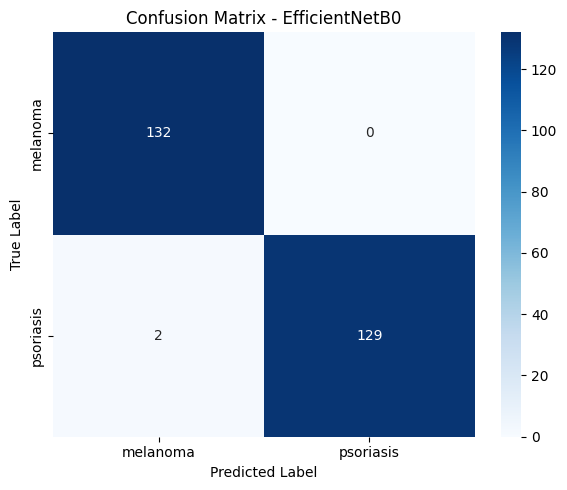

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Ambil ulang nama kelas
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset_kulit/split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
class_names = raw_test_ds.class_names

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNetB0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Simpan confusion matrix ke file
plt.savefig('/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
if len(class_names) == 2 and cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print("\nRincian Confusion Matrix:")
    print(f"True Positive  (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative  (TN): {tn}")
else:
    print("TP-FP-FN-TN hanya berlaku untuk klasifikasi biner.")


Rincian Confusion Matrix:
True Positive  (TP): 129
False Positive (FP): 0
False Negative (FN): 2
True Negative  (TN): 132


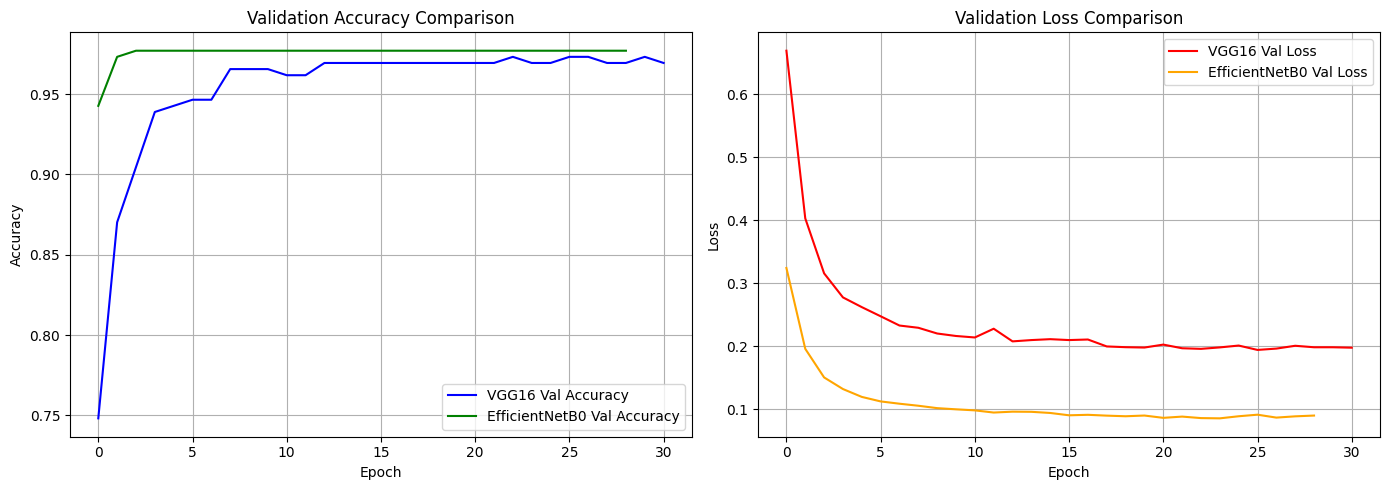

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path CSV log
vgg_log_path = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_training_log.csv'
eff_log_path = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_training_log.csv'

# Load logs
vgg_log = pd.read_csv(vgg_log_path)
eff_log = pd.read_csv(eff_log_path)

# Plot komparasi akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_log['val_accuracy'], label='VGG16 Val Accuracy', color='blue')
plt.plot(eff_log['val_accuracy'], label='EfficientNetB0 Val Accuracy', color='green')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot komparasi loss
plt.subplot(1, 2, 2)
plt.plot(vgg_log['val_loss'], label='VGG16 Val Loss', color='red')
plt.plot(eff_log['val_loss'], label='EfficientNetB0 Val Loss', color='orange')
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dataset_kulit/logs/model_comparison_val.png', dpi=300)
plt.show()

In [ ]:
# Masukkan hasil evaluasi test model (dari sebelumnya)
vgg_test_acc = 0.9848
vgg_test_loss = 0.0832

eff_test_acc = 0.9848
eff_test_loss = 0.0988

# Tampilkan
print("\nPERBANDINGAN HASIL EVALUASI TEST SET")
print(f"VGG16         - Accuracy: {vgg_test_acc:.4f}, Loss: {vgg_test_loss:.4f}")
print(f"EfficientNetB0 - Accuracy: {eff_test_acc:.4f}, Loss: {eff_test_loss:.4f}")


PERBANDINGAN HASIL EVALUASI TEST SET
VGG16         - Accuracy: 0.9848, Loss: 0.0832
EfficientNetB0 - Accuracy: 0.9848, Loss: 0.0988


In [ ]:
# Path ke file classification report
vgg_report_csv = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_classification_report.csv'
eff_report_csv = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_classification_report.csv'

# Load
vgg_report = pd.read_csv(vgg_report_csv, index_col=0)
eff_report = pd.read_csv(eff_report_csv, index_col=0)

# Tampilkan nilai f1-score per kelas
print("\nF1-Score Per Kelas:")
print("VGG16:")
print(vgg_report[['f1-score']].head(2))  # melanoma & psoriasis

print("\nEfficientNetB0:")
print(eff_report[['f1-score']].head(2))


F1-Score Per Kelas:
VGG16:
           f1-score
melanoma   0.980989
psoriasis  0.980989

EfficientNetB0:
           f1-score
melanoma   0.992481
psoriasis  0.992308


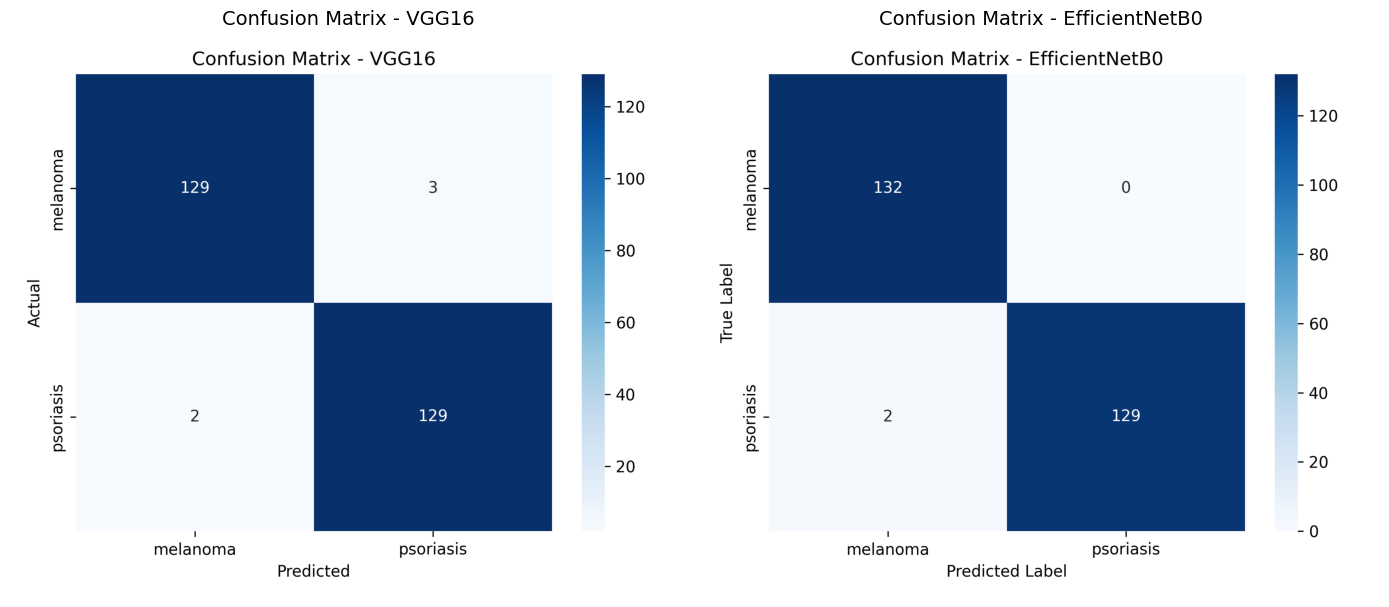

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path gambar Confusion Matrix
vgg_path = '/content/drive/MyDrive/dataset_kulit/logs/vgg16_confusion_matrix.png'
eff_path = '/content/drive/MyDrive/dataset_kulit/logs/efficientnetb0_confusion_matrix.png'

# Buat figure side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Load dan tampilkan VGG16
axes[0].imshow(mpimg.imread(vgg_path))
axes[0].axis('off')
axes[0].set_title("Confusion Matrix - VGG16", fontsize=14)

# Load dan tampilkan EfficientNetB0
axes[1].imshow(mpimg.imread(eff_path))
axes[1].axis('off')
axes[1].set_title("Confusion Matrix - EfficientNetB0", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# MODEL VGG16
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/dataset_kulit/models/best_vgg16_model.h5')
# MODEL EfficientNetB0
eff_model = tf.keras.models.load_model('/content/drive/MyDrive/dataset_kulit/models/best_efficientnetb0_model.h5')

# Ambil label asli
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_true_cls = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true

# Prediksi probabilitas dari kedua model
y_pred_vgg_probs = vgg_model.predict(test_ds)
y_pred_efficient_probs = eff_model.predict(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 784ms/step


# **HASIL PERBADINGAN MODEL VGG16 & EFFICIENETB0**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Konversi prediksi probabilitas ke kelas prediksi
y_pred_vgg = np.argmax(y_pred_vgg_probs, axis=1)
y_pred_eff = np.argmax(y_pred_efficient_probs, axis=1)
y_true_cls = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true

# Fungsi helper untuk specificity
def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):  # binary only
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        specificity = np.nan  # N/A for multi-class
    return specificity

# Hitung metrik untuk VGG16
vgg_metrics = {
    'Accuracy': accuracy_score(y_true_cls, y_pred_vgg),
    'Precision': precision_score(y_true_cls, y_pred_vgg, average='binary'),
    'Recall': recall_score(y_true_cls, y_pred_vgg, average='binary'),
    'F1-Score': f1_score(y_true_cls, y_pred_vgg, average='binary'),
    'AUC': roc_auc_score(y_true_cls, y_pred_vgg),
    'Specificity': compute_specificity(y_true_cls, y_pred_vgg)
}

# Hitung metrik untuk EfficientNetB0
eff_metrics = {
    'Accuracy': accuracy_score(y_true_cls, y_pred_eff),
    'Precision': precision_score(y_true_cls, y_pred_eff, average='binary'),
    'Recall': recall_score(y_true_cls, y_pred_eff, average='binary'),
    'F1-Score': f1_score(y_true_cls, y_pred_eff, average='binary'),
    'AUC': roc_auc_score(y_true_cls, y_pred_eff),
    'Specificity': compute_specificity(y_true_cls, y_pred_eff)
}

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'VGG16': vgg_metrics,
    'EfficientNetB0': eff_metrics
}).round(4)

# Tampilkan dan simpan ke CSV
print("Tabel Perbandingan Metrik Klasifikasi:\n")
print(comparison_df)

comparison_df.to_csv('/content/classification_comparison_table.csv')
print("\nTabel disimpan ke: /content/classification_comparison_table.csv")

Tabel Perbandingan Metrik Klasifikasi:

              VGG16  EfficientNetB0
Accuracy     0.9163          0.9924
Precision    0.9910          1.0000
Recall       0.8397          0.9847
F1-Score     0.9091          0.9923
AUC          0.9161          0.9924
Specificity  0.9924          1.0000

Tabel disimpan ke: /content/classification_comparison_table.csv
